### This notebook generates spinless BBH waveform template as in Heurta's paper

* All waveform is saved in a single HDF5 file, with filename defined as HDF5_FILE
* For testing purpose and reducing the file size, only Hplus component of waveform with smaller sampling rate are generated. I also generate a coarser template bank with delta_M = 2 (Heurta use 1)


/usr/lib64/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



('Numbers of waveforms : ', 2580)


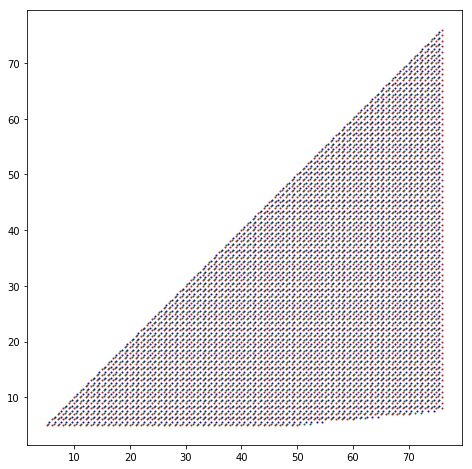

In [1]:
##
##  First, let'e make a (m1,m2) parameter table for the template
##

import pycbc
from pycbc.waveform import td_approximants, fd_approximants, get_td_waveform
import matplotlib.pyplot as plt
%matplotlib inline
import itertools

def templatebank(minm=5, maxm=75, dm=4, shift=0, max_ratio=10):
    m1a=[]
    m2a=[]
    for n1 in range(minm, maxm + dm, dm):     
        for n2 in range(n1, maxm + dm, dm):    ###  m2>=m1
            m1= n1 + shift
            m2= n2 + shift
            if (float(m2)/m1<=max_ratio):
                m1a.append(m1)
                m2a.append(m2)
    return m1a, m2a
    
dM = 4  ## 202  training set
dM = 2  ## 686  training set
dM = 1  ## 2580 training set
m1a, m2a = templatebank(5, 75+dM, dM, shift=0    )
m1b, m2b = templatebank(5, 75   , dM, shift=dM/2.)
m1c, m2c = templatebank(5, 75   , dM, shift=dM/4.)
                        
print ("Numbers of waveforms : ", len(m1a))            
plt.figure(figsize=(8,8))
plt.plot(m2a, m1a, 'r.', markersize=2)
plt.plot(m2b, m1b, 'b.', markersize=2)
plt.plot(m2c, m1c, 'g.', markersize=2)
plt.axes().set_aspect('equal')
plt.show()

In [59]:
import pycbc.waveform
##
##  This function tell you all TD / FD waveform model supported in pyCBC.
##  We will use SEOBNRv4
##

import pycbc
print ("== TD ================")
print (pycbc.waveform.td_approximants())
print ("== FD ================")
print (pycbc.waveform.fd_approximants())


== TD ================
['TEOBResum_ROM', 'TaylorEt', 'SEOBNRv3_opt', 'IMRPhenomA', 'IMRPhenomC', 'IMRPhenomB', 'EOBNRv2', 'NRSur7dq2', 'TEOBv4', 'SEOBNRv4_opt', 'PhenSpinTaylor', 'PhenSpinTaylorRD', 'NR_hdf5', 'TEOBv2', 'SEOBNRv3_pert', 'EOBNRv2HM', 'SpinTaylorT4', 'TaylorT1', 'TaylorT3', 'TaylorT2', 'HGimri', 'TaylorT4', 'IMRPhenomD', 'IMRPhenomPv2', 'SEOBNRv1', 'SpinDominatedWf', 'SEOBNRv3', 'SEOBNRv2', 'SpinTaylorT1', 'SEOBNRv4', 'SpinTaylorT2', 'EccentricTD', 'SEOBNRv2_opt', 'SEOBNRv3_opt_rk4']
== FD ================
['IMRPhenomD_NRTidal', 'TaylorF2', 'SEOBNRv2_ROM_EffectiveSpin', 'IMRPhenomA', 'IMRPhenomC', 'IMRPhenomB', 'IMRPhenomD', 'SpinTaylorT2Fourier', 'IMRPhenomPv2_INTERP', 'SpinTaylorT4Fourier', 'TaylorF2NLTides', 'IMRPhenomD_INTERP', 'SEOBNRv2_ROM_DoubleSpin', 'IMRPhenomP', 'SEOBNRv4_ROM_NRTidal', 'SpinTaylorF2', 'SEOBNRv2_ROM_DoubleSpin_INTERP', 'SEOBNRv1_ROM_DoubleSpin_INTERP', 'EOBNRv2_ROM_INTERP', 'TaylorF2_INTERP', 'SEOBNRv2_ROM_DoubleSpin_HI', 'SpinTaylorF2_INTERP', 

0.056653673125
93


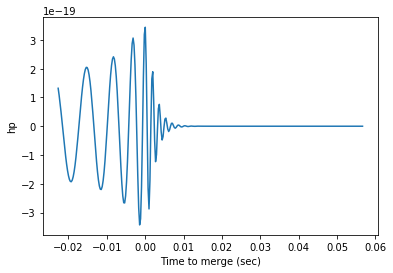

In [2]:
###
###  For you yo get a feeling about the waveform, here m=(5,5) waveform is plotted.
###

import pycbc.psd

import matplotlib.pyplot as plt
%matplotlib inline

import itertools

RATE = 8192
RATE = 4096
apx='SEOBNRv4'
#for m1,m2 in itertools.izip(m1a,m2a):

for m1,m2 in itertools.izip([15],[15]):
    hp, hc = pycbc.waveform.get_td_waveform(approximant=apx,
             mass1=m1, mass2=m2, spin1z=0, delta_t=1.0/RATE, f_lower=110.0)

    print hp.sample_times[-1]     
    plt.plot(hp.sample_times, hp, label=apx)
    plt.xlabel("Time to merge (sec)")
    plt.ylabel("hp")
    
    for i in range(len(hp.sample_times)):
        if hp.sample_times[i]>0: 
            print i
            break
        


In [3]:
"""
Estimate low freq at the 'time to merger'
Ref: Eq.8 in 1608.01940
"""
import numpy as np

GM0 = 6.674e-11 * 1.9891e30
c   = 299792458.
C1=5**(3/8.)/(8*np.pi) * ((c**3)/GM0)**(5./8) 

def time2lowfreq(m1,m2,t):
    Mcf= (m1*m2)**(-0.375) * (m1+m2)**(0.125)
    freq = C1 * Mcf * (t*1.4)**(-0.375)    ## here I add factor 1.4 just to get a longer waveform
    
    return freq 
    

In [4]:
##
##  Write to HDF5
##
import pycbc.psd
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import h5py

###
RATE      = 8192  # sampling rate 
RATE      = 4096 
apx       = 'SEOBNRv4'
dt = 1.0/RATE

#################  

list = [ ['train', m1a, m2a], 
         ['val',   m1b, m2b], 
         ['test',  m1c, m2c]  ]
## the loop will generate h5 files for each set
for item in list:
    HDF5_FILE = 'bbh_%d_dm%1d_%s.h5' % (RATE, dM, item[0])

    try:
        f = h5py.File(HDF5_FILE, 'w', libver='latest')
    except:
        f.close()
        f = h5py.File(HDF5_FILE, 'w', libver='latest')

    ###
    main_grp = f.create_group("/waveform")
    main_grp.attrs['srate'] = RATE
    main_grp.attrs['model'] = apx
    main_grp.attrs['desc'] = "Spinless BBH waveform model"

    ###
    count = 0
    for m1,m2 in itertools.izip(item[1],item[2]):

        f_low = time2lowfreq(m1,m2,2.0)   ## estimate the cutoff to have ~2 sec signal

        hp, hc = pycbc.waveform.get_td_waveform(approximant=apx,
            mass1=m1, mass2=m2, spin1z=0, delta_t=dt, f_lower=f_low)

        gname = "%s" % count    

        l = len(hp.sample_times)
        midx = 0    ### fixed merger index
        for i in range(l-1,0,-1):
            if hp.sample_times[i]<0: 
                midx = i
                break

        print ("%s #%d with mass %.1f, %.1f, f_low = %.1f, t=[%f %f] (#pts %d %d)..." 
               % (item[0], count, m1, m2, f_low, hp.sample_times[0],hp.sample_times[-1], len(hp.sample_times), midx ))

        grp = main_grp.create_group(gname)
        grp.attrs['m'] = [m1,m2]
        grp.attrs['sz'] = [0,0]
        grp.attrs['F_low'] = f_low
        #grp.create_dataset("t2m",  data=hp.sample_times, dtype='f')  # compression='gzip'
        grp.attrs['midx'] = midx
        grp.create_dataset("hp",  data=hp, dtype='f') #, compression='gzip'
        grp.create_dataset("hc",  data=hc, dtype='f') #, compression='gzip'

        count = count+1
        #if (count > 4):         break

    f.close()
    print ("Write : ", HDF5_FILE)


train #0 with mass 5.0, 5.0, f_low = 40.9, t=[-2.805093 0.018882] (#pts 11568 11489)...
train #1 with mass 5.0, 6.0, f_low = 38.7, t=[-2.798915 0.020665] (#pts 11550 11464)...
train #2 with mass 5.0, 7.0, f_low = 36.9, t=[-2.790653 0.022579] (#pts 11524 11430)...
train #3 with mass 5.0, 8.0, f_low = 35.5, t=[-2.781012 0.024408] (#pts 11492 11391)...
train #4 with mass 5.0, 9.0, f_low = 34.2, t=[-2.770419 0.026212] (#pts 11456 11347)...
train #5 with mass 5.0, 10.0, f_low = 33.2, t=[-2.759151 0.027958] (#pts 11417 11301)...
train #6 with mass 5.0, 11.0, f_low = 32.3, t=[-2.747386 0.029713] (#pts 11376 11253)...
train #7 with mass 5.0, 12.0, f_low = 31.5, t=[-2.735252 0.031593] (#pts 11334 11203)...
train #8 with mass 5.0, 13.0, f_low = 30.8, t=[-2.722835 0.033513] (#pts 11291 11152)...
train #9 with mass 5.0, 14.0, f_low = 30.1, t=[-2.710197 0.035408] (#pts 11247 11100)...
train #10 with mass 5.0, 15.0, f_low = 29.6, t=[-2.697390 0.037230] (#pts 11202 11048)...
train #11 with mass 5.0, 

train #92 with mass 6.0, 52.0, f_low = 19.8, t=[-2.267945 0.107299] (#pts 9730 9289)...
train #93 with mass 6.0, 53.0, f_low = 19.7, t=[-2.256046 0.109188] (#pts 9689 9240)...
train #94 with mass 6.0, 54.0, f_low = 19.6, t=[-2.244164 0.111061] (#pts 9648 9192)...
train #95 with mass 6.0, 55.0, f_low = 19.5, t=[-2.232296 0.112918] (#pts 9607 9143)...
train #96 with mass 6.0, 56.0, f_low = 19.4, t=[-2.220459 0.114746] (#pts 9566 9094)...
train #97 with mass 6.0, 57.0, f_low = 19.3, t=[-2.208634 0.116805] (#pts 9526 9046)...
train #98 with mass 6.0, 58.0, f_low = 19.2, t=[-2.196835 0.118594] (#pts 9485 8998)...
train #99 with mass 6.0, 59.0, f_low = 19.1, t=[-2.185062 0.120358] (#pts 9444 8950)...
train #100 with mass 6.0, 60.0, f_low = 19.1, t=[-2.173303 0.122107] (#pts 9403 8901)...
train #101 with mass 7.0, 7.0, f_low = 33.2, t=[-2.787197 0.026279] (#pts 11525 11416)...
train #102 with mass 7.0, 8.0, f_low = 31.8, t=[-2.782153 0.028150] (#pts 11512 11395)...
train #103 with mass 7.0, 9

train #183 with mass 8.0, 26.0, f_low = 21.6, t=[-2.623114 0.063165] (#pts 11004 10744)...
train #184 with mass 8.0, 27.0, f_low = 21.3, t=[-2.612931 0.065048] (#pts 10970 10702)...
train #185 with mass 8.0, 28.0, f_low = 21.1, t=[-2.602707 0.066726] (#pts 10935 10660)...
train #186 with mass 8.0, 29.0, f_low = 20.9, t=[-2.592453 0.068680] (#pts 10901 10618)...
train #187 with mass 8.0, 30.0, f_low = 20.7, t=[-2.582169 0.070419] (#pts 10866 10576)...
train #188 with mass 8.0, 31.0, f_low = 20.5, t=[-2.571861 0.072426] (#pts 10832 10534)...
train #189 with mass 8.0, 32.0, f_low = 20.3, t=[-2.561531 0.074455] (#pts 10798 10492)...
train #190 with mass 8.0, 33.0, f_low = 20.2, t=[-2.551186 0.076256] (#pts 10763 10449)...
train #191 with mass 8.0, 34.0, f_low = 20.0, t=[-2.540825 0.078072] (#pts 10728 10407)...
train #192 with mass 8.0, 35.0, f_low = 19.9, t=[-2.530453 0.079899] (#pts 10693 10364)...
train #193 with mass 8.0, 36.0, f_low = 19.7, t=[-2.520067 0.081740] (#pts 10658 10322)...

train #274 with mass 9.0, 49.0, f_low = 17.4, t=[-2.414837 0.107624] (#pts 10333 9891)...
train #275 with mass 9.0, 50.0, f_low = 17.3, t=[-2.405109 0.109295] (#pts 10300 9851)...
train #276 with mass 9.0, 51.0, f_low = 17.2, t=[-2.395390 0.111202] (#pts 10268 9811)...
train #277 with mass 9.0, 52.0, f_low = 17.1, t=[-2.385670 0.113109] (#pts 10236 9771)...
train #278 with mass 9.0, 53.0, f_low = 17.0, t=[-2.375962 0.115005] (#pts 10204 9731)...
train #279 with mass 9.0, 54.0, f_low = 16.9, t=[-2.366261 0.116893] (#pts 10172 9692)...
train #280 with mass 9.0, 55.0, f_low = 16.9, t=[-2.356569 0.118529] (#pts 10139 9652)...
train #281 with mass 9.0, 56.0, f_low = 16.8, t=[-2.346889 0.120396] (#pts 10107 9612)...
train #282 with mass 9.0, 57.0, f_low = 16.7, t=[-2.337215 0.122257] (#pts 10075 9573)...
train #283 with mass 9.0, 58.0, f_low = 16.6, t=[-2.327549 0.124111] (#pts 10043 9533)...
train #284 with mass 9.0, 59.0, f_low = 16.5, t=[-2.317894 0.125954] (#pts 10011 9494)...
train #285

train #365 with mass 10.0, 73.0, f_low = 15.0, t=[-2.221031 0.153969] (#pts 9729 9097)...
train #366 with mass 10.0, 74.0, f_low = 15.0, t=[-2.212036 0.155884] (#pts 9700 9060)...
train #367 with mass 10.0, 75.0, f_low = 14.9, t=[-2.203056 0.157539] (#pts 9670 9023)...
train #368 with mass 10.0, 76.0, f_low = 14.9, t=[-2.194077 0.159438] (#pts 9641 8986)...
train #369 with mass 11.0, 11.0, f_low = 25.0, t=[-2.756878 0.041462] (#pts 11463 11292)...
train #370 with mass 11.0, 12.0, f_low = 24.3, t=[-2.752996 0.043390] (#pts 11455 11276)...
train #371 with mass 11.0, 13.0, f_low = 23.7, t=[-2.748366 0.045335] (#pts 11444 11257)...
train #372 with mass 11.0, 14.0, f_low = 23.2, t=[-2.743126 0.047157] (#pts 11430 11235)...
train #373 with mass 11.0, 15.0, f_low = 22.7, t=[-2.737389 0.048988] (#pts 11414 11212)...
train #374 with mass 11.0, 16.0, f_low = 22.3, t=[-2.731232 0.050751] (#pts 11396 11187)...
train #375 with mass 11.0, 17.0, f_low = 21.9, t=[-2.724730 0.052613] (#pts 11377 11160)

train #455 with mass 12.0, 32.0, f_low = 17.7, t=[-2.617631 0.082320] (#pts 11060 10721)...
train #456 with mass 12.0, 33.0, f_low = 17.5, t=[-2.609689 0.084159] (#pts 11035 10689)...
train #457 with mass 12.0, 34.0, f_low = 17.4, t=[-2.601705 0.085795] (#pts 11009 10656)...
train #458 with mass 12.0, 35.0, f_low = 17.2, t=[-2.593682 0.087714] (#pts 10984 10623)...
train #459 with mass 12.0, 36.0, f_low = 17.1, t=[-2.585626 0.089422] (#pts 10958 10590)...
train #460 with mass 12.0, 37.0, f_low = 17.0, t=[-2.577545 0.091400] (#pts 10933 10557)...
train #461 with mass 12.0, 38.0, f_low = 16.8, t=[-2.569431 0.093166] (#pts 10907 10524)...
train #462 with mass 12.0, 39.0, f_low = 16.7, t=[-2.561288 0.094962] (#pts 10881 10491)...
train #463 with mass 12.0, 40.0, f_low = 16.6, t=[-2.553128 0.096774] (#pts 10855 10457)...
train #464 with mass 12.0, 41.0, f_low = 16.5, t=[-2.544952 0.098602] (#pts 10829 10424)...
train #465 with mass 12.0, 42.0, f_low = 16.4, t=[-2.536751 0.100456] (#pts 1080

train #545 with mass 13.0, 58.0, f_low = 14.6, t=[-2.423527 0.131649] (#pts 10467 9926)...
train #546 with mass 13.0, 59.0, f_low = 14.5, t=[-2.415600 0.133717] (#pts 10443 9894)...
train #547 with mass 13.0, 60.0, f_low = 14.4, t=[-2.407678 0.135535] (#pts 10418 9861)...
train #548 with mass 13.0, 61.0, f_low = 14.4, t=[-2.399761 0.137348] (#pts 10393 9829)...
train #549 with mass 13.0, 62.0, f_low = 14.3, t=[-2.391836 0.139170] (#pts 10368 9796)...
train #550 with mass 13.0, 63.0, f_low = 14.3, t=[-2.383923 0.140980] (#pts 10343 9764)...
train #551 with mass 13.0, 64.0, f_low = 14.2, t=[-2.376007 0.143036] (#pts 10319 9732)...
train #552 with mass 13.0, 65.0, f_low = 14.1, t=[-2.368088 0.144851] (#pts 10294 9699)...
train #553 with mass 13.0, 66.0, f_low = 14.1, t=[-2.360178 0.146658] (#pts 10269 9667)...
train #554 with mass 13.0, 67.0, f_low = 14.0, t=[-2.352280 0.148697] (#pts 10245 9634)...
train #555 with mass 13.0, 68.0, f_low = 14.0, t=[-2.344368 0.150505] (#pts 10220 9602)...

train #635 with mass 15.0, 23.0, f_low = 18.1, t=[-2.694880 0.071477] (#pts 11332 11038)...
train #636 with mass 15.0, 24.0, f_low = 17.8, t=[-2.689175 0.073521] (#pts 11317 11014)...
train #637 with mass 15.0, 25.0, f_low = 17.6, t=[-2.683309 0.075236] (#pts 11300 10990)...
train #638 with mass 15.0, 26.0, f_low = 17.4, t=[-2.677307 0.077087] (#pts 11283 10966)...
train #639 with mass 15.0, 27.0, f_low = 17.2, t=[-2.671173 0.079071] (#pts 11266 10941)...
train #640 with mass 15.0, 28.0, f_low = 17.1, t=[-2.664922 0.080927] (#pts 11248 10915)...
train #641 with mass 15.0, 29.0, f_low = 16.9, t=[-2.658581 0.082630] (#pts 11229 10889)...
train #642 with mass 15.0, 30.0, f_low = 16.7, t=[-2.652142 0.084431] (#pts 11210 10863)...
train #643 with mass 15.0, 31.0, f_low = 16.6, t=[-2.645622 0.086311] (#pts 11191 10836)...
train #644 with mass 15.0, 32.0, f_low = 16.4, t=[-2.639024 0.088027] (#pts 11171 10809)...
train #645 with mass 15.0, 33.0, f_low = 16.3, t=[-2.632364 0.090048] (#pts 1115

train #725 with mass 16.0, 52.0, f_low = 14.0, t=[-2.510026 0.126693] (#pts 10801 10281)...
train #726 with mass 16.0, 53.0, f_low = 13.9, t=[-2.503086 0.128506] (#pts 10780 10252)...
train #727 with mass 16.0, 54.0, f_low = 13.8, t=[-2.496125 0.130340] (#pts 10759 10224)...
train #728 with mass 16.0, 55.0, f_low = 13.8, t=[-2.489159 0.132179] (#pts 10738 10195)...
train #729 with mass 16.0, 56.0, f_low = 13.7, t=[-2.482183 0.134028] (#pts 10717 10167)...
train #730 with mass 16.0, 57.0, f_low = 13.6, t=[-2.475199 0.135885] (#pts 10696 10138)...
train #731 with mass 16.0, 58.0, f_low = 13.6, t=[-2.468212 0.137501] (#pts 10674 10109)...
train #732 with mass 16.0, 59.0, f_low = 13.5, t=[-2.461212 0.139374] (#pts 10653 10081)...
train #733 with mass 16.0, 60.0, f_low = 13.4, t=[-2.454208 0.141251] (#pts 10632 10052)...
train #734 with mass 16.0, 61.0, f_low = 13.4, t=[-2.447193 0.143383] (#pts 10612 10023)...
train #735 with mass 16.0, 62.0, f_low = 13.3, t=[-2.440178 0.145271] (#pts 1059

train #815 with mass 18.0, 23.0, f_low = 17.0, t=[-2.696232 0.077450] (#pts 11362 11043)...
train #816 with mass 18.0, 24.0, f_low = 16.8, t=[-2.691831 0.079409] (#pts 11352 11025)...
train #817 with mass 18.0, 25.0, f_low = 16.6, t=[-2.687241 0.081314] (#pts 11341 11006)...
train #818 with mass 18.0, 26.0, f_low = 16.4, t=[-2.682465 0.083160] (#pts 11329 10987)...
train #819 with mass 18.0, 27.0, f_low = 16.2, t=[-2.677528 0.084923] (#pts 11316 10967)...
train #820 with mass 18.0, 28.0, f_low = 16.1, t=[-2.672445 0.086833] (#pts 11303 10946)...
train #821 with mass 18.0, 29.0, f_low = 15.9, t=[-2.667240 0.088619] (#pts 11289 10925)...
train #822 with mass 18.0, 30.0, f_low = 15.7, t=[-2.661911 0.090530] (#pts 11275 10903)...
train #823 with mass 18.0, 31.0, f_low = 15.6, t=[-2.656481 0.092299] (#pts 11260 10880)...
train #824 with mass 18.0, 32.0, f_low = 15.4, t=[-2.650959 0.094158] (#pts 11245 10858)...
train #825 with mass 18.0, 33.0, f_low = 15.3, t=[-2.645342 0.095869] (#pts 1122

train #905 with mass 19.0, 55.0, f_low = 13.0, t=[-2.518478 0.138016] (#pts 10882 10315)...
train #906 with mass 19.0, 56.0, f_low = 12.9, t=[-2.512260 0.139839] (#pts 10864 10290)...
train #907 with mass 19.0, 57.0, f_low = 12.8, t=[-2.506031 0.141674] (#pts 10846 10264)...
train #908 with mass 19.0, 58.0, f_low = 12.8, t=[-2.499786 0.143768] (#pts 10829 10239)...
train #909 with mass 19.0, 59.0, f_low = 12.7, t=[-2.493525 0.145635] (#pts 10811 10213)...
train #910 with mass 19.0, 60.0, f_low = 12.7, t=[-2.487267 0.147499] (#pts 10793 10187)...
train #911 with mass 19.0, 61.0, f_low = 12.6, t=[-2.480988 0.149384] (#pts 10775 10162)...
train #912 with mass 19.0, 62.0, f_low = 12.5, t=[-2.474701 0.151031] (#pts 10756 10136)...
train #913 with mass 19.0, 63.0, f_low = 12.5, t=[-2.468407 0.152931] (#pts 10738 10110)...
train #914 with mass 19.0, 64.0, f_low = 12.4, t=[-2.462092 0.154608] (#pts 10719 10084)...
train #915 with mass 19.0, 65.0, f_low = 12.4, t=[-2.455788 0.156517] (#pts 1070

train #995 with mass 21.0, 32.0, f_low = 14.7, t=[-2.656762 0.100073] (#pts 11293 10882)...
train #996 with mass 21.0, 33.0, f_low = 14.5, t=[-2.652050 0.101856] (#pts 11281 10862)...
train #997 with mass 21.0, 34.0, f_low = 14.4, t=[-2.647240 0.103736] (#pts 11269 10843)...
train #998 with mass 21.0, 35.0, f_low = 14.3, t=[-2.642345 0.105457] (#pts 11256 10823)...
train #999 with mass 21.0, 36.0, f_low = 14.2, t=[-2.637363 0.107265] (#pts 11243 10802)...
train #1000 with mass 21.0, 37.0, f_low = 14.1, t=[-2.632303 0.109152] (#pts 11230 10781)...
train #1001 with mass 21.0, 38.0, f_low = 13.9, t=[-2.627182 0.110855] (#pts 11216 10760)...
train #1002 with mass 21.0, 39.0, f_low = 13.8, t=[-2.621987 0.112876] (#pts 11203 10739)...
train #1003 with mass 21.0, 40.0, f_low = 13.7, t=[-2.616738 0.114707] (#pts 11189 10718)...
train #1004 with mass 21.0, 41.0, f_low = 13.6, t=[-2.611435 0.116348] (#pts 11174 10696)...
train #1005 with mass 21.0, 42.0, f_low = 13.5, t=[-2.606087 0.118279] (#pt

train #1084 with mass 22.0, 66.0, f_low = 11.7, t=[-2.477197 0.164404] (#pts 10821 10146)...
train #1085 with mass 22.0, 67.0, f_low = 11.7, t=[-2.471461 0.165991] (#pts 10804 10123)...
train #1086 with mass 22.0, 68.0, f_low = 11.6, t=[-2.465714 0.168075] (#pts 10789 10099)...
train #1087 with mass 22.0, 69.0, f_low = 11.6, t=[-2.459969 0.169914] (#pts 10773 10076)...
train #1088 with mass 22.0, 70.0, f_low = 11.5, t=[-2.454197 0.171536] (#pts 10756 10052)...
train #1089 with mass 22.0, 71.0, f_low = 11.5, t=[-2.448426 0.173400] (#pts 10740 10028)...
train #1090 with mass 22.0, 72.0, f_low = 11.4, t=[-2.442657 0.175262] (#pts 10724 10005)...
train #1091 with mass 22.0, 73.0, f_low = 11.4, t=[-2.436874 0.177139] (#pts 10708 9981)...
train #1092 with mass 22.0, 74.0, f_low = 11.3, t=[-2.431078 0.178785] (#pts 10691 9957)...
train #1093 with mass 22.0, 75.0, f_low = 11.3, t=[-2.425293 0.180664] (#pts 10675 9933)...
train #1094 with mass 22.0, 76.0, f_low = 11.3, t=[-2.419495 0.182556] (#

train #1173 with mass 24.0, 48.0, f_low = 12.5, t=[-2.585808 0.135139] (#pts 11146 10591)...
train #1174 with mass 24.0, 49.0, f_low = 12.4, t=[-2.580803 0.136970] (#pts 11133 10570)...
train #1175 with mass 24.0, 50.0, f_low = 12.3, t=[-2.575764 0.138836] (#pts 11120 10550)...
train #1176 with mass 24.0, 51.0, f_low = 12.2, t=[-2.570698 0.140484] (#pts 11106 10529)...
train #1177 with mass 24.0, 52.0, f_low = 12.2, t=[-2.565594 0.142414] (#pts 11093 10508)...
train #1178 with mass 24.0, 53.0, f_low = 12.1, t=[-2.560463 0.144371] (#pts 11080 10487)...
train #1179 with mass 24.0, 54.0, f_low = 12.0, t=[-2.555299 0.146361] (#pts 11067 10466)...
train #1180 with mass 24.0, 55.0, f_low = 12.0, t=[-2.550125 0.148117] (#pts 11053 10445)...
train #1181 with mass 24.0, 56.0, f_low = 11.9, t=[-2.544907 0.149917] (#pts 11039 10423)...
train #1182 with mass 24.0, 57.0, f_low = 11.9, t=[-2.539688 0.151718] (#pts 11025 10402)...
train #1183 with mass 24.0, 58.0, f_low = 11.8, t=[-2.534426 0.153563]

train #1262 with mass 26.0, 34.0, f_low = 13.4, t=[-2.650598 0.113318] (#pts 11322 10856)...
train #1263 with mass 26.0, 35.0, f_low = 13.3, t=[-2.646935 0.115272] (#pts 11315 10841)...
train #1264 with mass 26.0, 36.0, f_low = 13.2, t=[-2.643164 0.117090] (#pts 11307 10826)...
train #1265 with mass 26.0, 37.0, f_low = 13.1, t=[-2.639297 0.119003] (#pts 11299 10810)...
train #1266 with mass 26.0, 38.0, f_low = 13.0, t=[-2.635328 0.120776] (#pts 11290 10794)...
train #1267 with mass 26.0, 39.0, f_low = 12.9, t=[-2.631283 0.122623] (#pts 11281 10777)...
train #1268 with mass 26.0, 40.0, f_low = 12.8, t=[-2.627149 0.124315] (#pts 11271 10760)...
train #1269 with mass 26.0, 41.0, f_low = 12.7, t=[-2.622952 0.126316] (#pts 11262 10743)...
train #1270 with mass 26.0, 42.0, f_low = 12.6, t=[-2.618676 0.128150] (#pts 11252 10726)...
train #1271 with mass 26.0, 43.0, f_low = 12.5, t=[-2.614342 0.129798] (#pts 11241 10708)...
train #1272 with mass 26.0, 44.0, f_low = 12.4, t=[-2.609949 0.131750]

train #1351 with mass 27.0, 73.0, f_low = 10.6, t=[-2.474435 0.186942] (#pts 10902 10135)...
train #1352 with mass 27.0, 74.0, f_low = 10.6, t=[-2.469415 0.188788] (#pts 10889 10114)...
train #1353 with mass 27.0, 75.0, f_low = 10.5, t=[-2.464394 0.190636] (#pts 10876 10094)...
train #1354 with mass 27.0, 76.0, f_low = 10.5, t=[-2.459345 0.192510] (#pts 10863 10073)...
train #1355 with mass 28.0, 28.0, f_low = 13.9, t=[-2.665838 0.105890] (#pts 11354 10919)...
train #1356 with mass 28.0, 29.0, f_low = 13.8, t=[-2.663578 0.107906] (#pts 11353 10910)...
train #1357 with mass 28.0, 30.0, f_low = 13.7, t=[-2.661118 0.109634] (#pts 11350 10899)...
train #1358 with mass 28.0, 31.0, f_low = 13.5, t=[-2.658478 0.111786] (#pts 11348 10889)...
train #1359 with mass 28.0, 32.0, f_low = 13.4, t=[-2.655672 0.113616] (#pts 11344 10877)...
train #1360 with mass 28.0, 33.0, f_low = 13.3, t=[-2.652719 0.115348] (#pts 11339 10865)...
train #1361 with mass 28.0, 34.0, f_low = 13.1, t=[-2.649631 0.117214]

train #1440 with mass 29.0, 65.0, f_low = 10.7, t=[-2.523156 0.176307] (#pts 11058 10334)...
train #1441 with mass 29.0, 66.0, f_low = 10.7, t=[-2.518517 0.178016] (#pts 11046 10315)...
train #1442 with mass 29.0, 67.0, f_low = 10.6, t=[-2.513870 0.179977] (#pts 11035 10296)...
train #1443 with mass 29.0, 68.0, f_low = 10.6, t=[-2.509189 0.181729] (#pts 11023 10277)...
train #1444 with mass 29.0, 69.0, f_low = 10.5, t=[-2.504509 0.183479] (#pts 11011 10258)...
train #1445 with mass 29.0, 70.0, f_low = 10.5, t=[-2.499796 0.185506] (#pts 11000 10239)...
train #1446 with mass 29.0, 71.0, f_low = 10.4, t=[-2.495087 0.187286] (#pts 10988 10219)...
train #1447 with mass 29.0, 72.0, f_low = 10.4, t=[-2.490356 0.189087] (#pts 10976 10200)...
train #1448 with mass 29.0, 73.0, f_low = 10.4, t=[-2.485611 0.190903] (#pts 10964 10181)...
train #1449 with mass 29.0, 74.0, f_low = 10.3, t=[-2.480858 0.192726] (#pts 10952 10161)...
train #1450 with mass 29.0, 75.0, f_low = 10.3, t=[-2.476089 0.194565]

train #1529 with mass 31.0, 61.0, f_low = 10.7, t=[-2.547916 0.173032] (#pts 11146 10436)...
train #1530 with mass 31.0, 62.0, f_low = 10.6, t=[-2.543626 0.174635] (#pts 11135 10418)...
train #1531 with mass 31.0, 63.0, f_low = 10.6, t=[-2.539322 0.176498] (#pts 11125 10401)...
train #1532 with mass 31.0, 64.0, f_low = 10.5, t=[-2.534977 0.178402] (#pts 11115 10383)...
train #1533 with mass 31.0, 65.0, f_low = 10.5, t=[-2.530619 0.180319] (#pts 11105 10365)...
train #1534 with mass 31.0, 66.0, f_low = 10.4, t=[-2.526240 0.182012] (#pts 11094 10347)...
train #1535 with mass 31.0, 67.0, f_low = 10.4, t=[-2.521851 0.183960] (#pts 11084 10329)...
train #1536 with mass 31.0, 68.0, f_low = 10.3, t=[-2.517433 0.185692] (#pts 11073 10311)...
train #1537 with mass 31.0, 69.0, f_low = 10.3, t=[-2.512989 0.187451] (#pts 11062 10293)...
train #1538 with mass 31.0, 70.0, f_low = 10.2, t=[-2.508545 0.189209] (#pts 11051 10274)...
train #1539 with mass 31.0, 71.0, f_low = 10.2, t=[-2.504069 0.191243]

train #1618 with mass 33.0, 61.0, f_low = 10.4, t=[-2.553080 0.176900] (#pts 11183 10457)...
train #1619 with mass 33.0, 62.0, f_low = 10.4, t=[-2.549044 0.178739] (#pts 11174 10440)...
train #1620 with mass 33.0, 63.0, f_low = 10.3, t=[-2.544991 0.180595] (#pts 11165 10424)...
train #1621 with mass 33.0, 64.0, f_low = 10.3, t=[-2.540901 0.182487] (#pts 11156 10407)...
train #1622 with mass 33.0, 65.0, f_low = 10.3, t=[-2.536789 0.184158] (#pts 11146 10390)...
train #1623 with mass 33.0, 66.0, f_low = 10.2, t=[-2.532654 0.186096] (#pts 11137 10373)...
train #1624 with mass 33.0, 67.0, f_low = 10.2, t=[-2.528496 0.187813] (#pts 11127 10356)...
train #1625 with mass 33.0, 68.0, f_low = 10.1, t=[-2.524308 0.189559] (#pts 11117 10339)...
train #1626 with mass 33.0, 69.0, f_low = 10.1, t=[-2.520119 0.191551] (#pts 11108 10322)...
train #1627 with mass 33.0, 70.0, f_low = 10.0, t=[-2.515894 0.193334] (#pts 11098 10305)...
train #1628 with mass 33.0, 71.0, f_low = 10.0, t=[-2.511660 0.195127]

train #1707 with mass 35.0, 65.0, f_low = 10.1, t=[-2.541819 0.188162] (#pts 11183 10411)...
train #1708 with mass 35.0, 66.0, f_low = 10.0, t=[-2.537913 0.189871] (#pts 11174 10395)...
train #1709 with mass 35.0, 67.0, f_low = 10.0, t=[-2.533983 0.191847] (#pts 11166 10379)...
train #1710 with mass 35.0, 68.0, f_low = 9.9, t=[-2.530030 0.193603] (#pts 11157 10363)...
train #1711 with mass 35.0, 69.0, f_low = 9.9, t=[-2.526056 0.195380] (#pts 11148 10346)...
train #1712 with mass 35.0, 70.0, f_low = 9.8, t=[-2.522072 0.197166] (#pts 11139 10330)...
train #1713 with mass 35.0, 71.0, f_low = 9.8, t=[-2.518047 0.198994] (#pts 11130 10313)...
train #1714 with mass 35.0, 72.0, f_low = 9.8, t=[-2.514023 0.200821] (#pts 11121 10297)...
train #1715 with mass 35.0, 73.0, f_low = 9.7, t=[-2.509972 0.202675] (#pts 11112 10280)...
train #1716 with mass 35.0, 74.0, f_low = 9.7, t=[-2.505894 0.204556] (#pts 11103 10264)...
train #1717 with mass 35.0, 75.0, f_low = 9.6, t=[-2.501809 0.206443] (#pts 1

train #1796 with mass 37.0, 73.0, f_low = 9.5, t=[-2.515711 0.206701] (#pts 11152 10304)...
train #1797 with mass 37.0, 74.0, f_low = 9.5, t=[-2.511856 0.208603] (#pts 11144 10288)...
train #1798 with mass 37.0, 75.0, f_low = 9.5, t=[-2.507973 0.210289] (#pts 11135 10272)...
train #1799 with mass 37.0, 76.0, f_low = 9.4, t=[-2.504062 0.212003] (#pts 11126 10256)...
train #1800 with mass 38.0, 38.0, f_low = 11.5, t=[-2.626229 0.143790] (#pts 11347 10757)...
train #1801 with mass 38.0, 39.0, f_low = 11.4, t=[-2.624348 0.145916] (#pts 11348 10749)...
train #1802 with mass 38.0, 40.0, f_low = 11.3, t=[-2.622345 0.147919] (#pts 11348 10741)...
train #1803 with mass 38.0, 41.0, f_low = 11.3, t=[-2.620211 0.149808] (#pts 11347 10732)...
train #1804 with mass 38.0, 42.0, f_low = 11.2, t=[-2.617989 0.151543] (#pts 11345 10723)...
train #1805 with mass 38.0, 43.0, f_low = 11.1, t=[-2.615647 0.153396] (#pts 11343 10713)...
train #1806 with mass 38.0, 44.0, f_low = 11.0, t=[-2.613228 0.155327] (#p

train #1885 with mass 40.0, 48.0, f_low = 10.5, t=[-2.601608 0.166702] (#pts 11340 10656)...
train #1886 with mass 40.0, 49.0, f_low = 10.5, t=[-2.599030 0.168548] (#pts 11337 10645)...
train #1887 with mass 40.0, 50.0, f_low = 10.4, t=[-2.596397 0.170448] (#pts 11334 10634)...
train #1888 with mass 40.0, 51.0, f_low = 10.4, t=[-2.593689 0.172180] (#pts 11330 10623)...
train #1889 with mass 40.0, 52.0, f_low = 10.3, t=[-2.590919 0.173973] (#pts 11326 10612)...
train #1890 with mass 40.0, 53.0, f_low = 10.2, t=[-2.588077 0.175839] (#pts 11322 10600)...
train #1891 with mass 40.0, 54.0, f_low = 10.2, t=[-2.585197 0.177742] (#pts 11318 10588)...
train #1892 with mass 40.0, 55.0, f_low = 10.1, t=[-2.582247 0.179472] (#pts 11313 10576)...
train #1893 with mass 40.0, 56.0, f_low = 10.1, t=[-2.579254 0.181488] (#pts 11309 10564)...
train #1894 with mass 40.0, 57.0, f_low = 10.0, t=[-2.576213 0.183309] (#pts 11304 10552)...
train #1895 with mass 40.0, 58.0, f_low = 10.0, t=[-2.573135 0.185165]

train #1974 with mass 42.0, 66.0, f_low = 9.4, t=[-2.549333 0.203841] (#pts 11278 10442)...
train #1975 with mass 42.0, 67.0, f_low = 9.4, t=[-2.546115 0.205594] (#pts 11272 10428)...
train #1976 with mass 42.0, 68.0, f_low = 9.3, t=[-2.542877 0.207367] (#pts 11266 10415)...
train #1977 with mass 42.0, 69.0, f_low = 9.3, t=[-2.539590 0.209189] (#pts 11260 10402)...
train #1978 with mass 42.0, 70.0, f_low = 9.3, t=[-2.536286 0.211028] (#pts 11254 10388)...
train #1979 with mass 42.0, 71.0, f_low = 9.2, t=[-2.532967 0.212883] (#pts 11248 10375)...
train #1980 with mass 42.0, 72.0, f_low = 9.2, t=[-2.529610 0.214775] (#pts 11242 10361)...
train #1981 with mass 42.0, 73.0, f_low = 9.2, t=[-2.526223 0.216697] (#pts 11236 10347)...
train #1982 with mass 42.0, 74.0, f_low = 9.1, t=[-2.522821 0.218634] (#pts 11230 10333)...
train #1983 with mass 42.0, 75.0, f_low = 9.1, t=[-2.519409 0.220337] (#pts 11223 10319)...
train #1984 with mass 42.0, 76.0, f_low = 9.0, t=[-2.515954 0.222083] (#pts 1121

train #2063 with mass 45.0, 56.0, f_low = 9.7, t=[-2.578820 0.191200] (#pts 11347 10562)...
train #2064 with mass 45.0, 57.0, f_low = 9.6, t=[-2.576310 0.192977] (#pts 11344 10552)...
train #2065 with mass 45.0, 58.0, f_low = 9.6, t=[-2.573748 0.194807] (#pts 11341 10542)...
train #2066 with mass 45.0, 59.0, f_low = 9.5, t=[-2.571144 0.196678] (#pts 11338 10531)...
train #2067 with mass 45.0, 60.0, f_low = 9.5, t=[-2.568481 0.198608] (#pts 11335 10520)...
train #2068 with mass 45.0, 61.0, f_low = 9.4, t=[-2.565773 0.200340] (#pts 11331 10509)...
train #2069 with mass 45.0, 62.0, f_low = 9.4, t=[-2.563013 0.202124] (#pts 11327 10498)...
train #2070 with mass 45.0, 63.0, f_low = 9.3, t=[-2.560226 0.204178] (#pts 11324 10486)...
train #2071 with mass 45.0, 64.0, f_low = 9.3, t=[-2.557396 0.205788] (#pts 11319 10475)...
train #2072 with mass 45.0, 65.0, f_low = 9.3, t=[-2.554513 0.207694] (#pts 11315 10463)...
train #2073 with mass 45.0, 66.0, f_low = 9.2, t=[-2.551613 0.209618] (#pts 1131

train #2152 with mass 48.0, 55.0, f_low = 9.5, t=[-2.579208 0.194962] (#pts 11364 10564)...
train #2153 with mass 48.0, 56.0, f_low = 9.5, t=[-2.577050 0.196876] (#pts 11363 10555)...
train #2154 with mass 48.0, 57.0, f_low = 9.4, t=[-2.574839 0.198842] (#pts 11362 10546)...
train #2155 with mass 48.0, 58.0, f_low = 9.4, t=[-2.572571 0.200622] (#pts 11360 10537)...
train #2156 with mass 48.0, 59.0, f_low = 9.3, t=[-2.570248 0.202457] (#pts 11358 10527)...
train #2157 with mass 48.0, 60.0, f_low = 9.3, t=[-2.567872 0.204345] (#pts 11356 10518)...
train #2158 with mass 48.0, 61.0, f_low = 9.2, t=[-2.565446 0.206283] (#pts 11354 10508)...
train #2159 with mass 48.0, 62.0, f_low = 9.2, t=[-2.562981 0.208015] (#pts 11351 10497)...
train #2160 with mass 48.0, 63.0, f_low = 9.2, t=[-2.560463 0.210045] (#pts 11349 10487)...
train #2161 with mass 48.0, 64.0, f_low = 9.1, t=[-2.557899 0.211632] (#pts 11345 10477)...
train #2162 with mass 48.0, 65.0, f_low = 9.1, t=[-2.555298 0.213745] (#pts 1134

train #2242 with mass 51.0, 64.0, f_low = 8.9, t=[-2.557360 0.217787] (#pts 11368 10474)...
train #2243 with mass 51.0, 65.0, f_low = 8.9, t=[-2.555023 0.219635] (#pts 11366 10465)...
train #2244 with mass 51.0, 66.0, f_low = 8.9, t=[-2.552621 0.221549] (#pts 11364 10455)...
train #2245 with mass 51.0, 67.0, f_low = 8.8, t=[-2.550189 0.223249] (#pts 11361 10445)...
train #2246 with mass 51.0, 68.0, f_low = 8.8, t=[-2.547717 0.225232] (#pts 11359 10435)...
train #2247 with mass 51.0, 69.0, f_low = 8.7, t=[-2.545208 0.227009] (#pts 11356 10425)...
train #2248 with mass 51.0, 70.0, f_low = 8.7, t=[-2.542671 0.229057] (#pts 11354 10414)...
train #2249 with mass 51.0, 71.0, f_low = 8.7, t=[-2.540092 0.230659] (#pts 11350 10404)...
train #2250 with mass 51.0, 72.0, f_low = 8.6, t=[-2.537470 0.232550] (#pts 11347 10393)...
train #2251 with mass 51.0, 73.0, f_low = 8.6, t=[-2.534836 0.234451] (#pts 11344 10382)...
train #2252 with mass 51.0, 74.0, f_low = 8.6, t=[-2.532158 0.236153] (#pts 1134

train #2332 with mass 55.0, 60.0, f_low = 8.9, t=[-2.562854 0.217908] (#pts 11391 10497)...
train #2333 with mass 55.0, 61.0, f_low = 8.9, t=[-2.561050 0.219955] (#pts 11392 10490)...
train #2334 with mass 55.0, 62.0, f_low = 8.8, t=[-2.559181 0.221825] (#pts 11392 10482)...
train #2335 with mass 55.0, 63.0, f_low = 8.8, t=[-2.557247 0.223759] (#pts 11392 10474)...
train #2336 with mass 55.0, 64.0, f_low = 8.7, t=[-2.555283 0.225479] (#pts 11391 10466)...
train #2337 with mass 55.0, 65.0, f_low = 8.7, t=[-2.553248 0.227270] (#pts 11390 10458)...
train #2338 with mass 55.0, 66.0, f_low = 8.6, t=[-2.551186 0.229088] (#pts 11389 10449)...
train #2339 with mass 55.0, 67.0, f_low = 8.6, t=[-2.549072 0.230957] (#pts 11388 10440)...
train #2340 with mass 55.0, 68.0, f_low = 8.6, t=[-2.546913 0.232872] (#pts 11387 10432)...
train #2341 with mass 55.0, 69.0, f_low = 8.5, t=[-2.544702 0.234839] (#pts 11386 10423)...
train #2342 with mass 55.0, 70.0, f_low = 8.5, t=[-2.542461 0.236591] (#pts 1138

train #2422 with mass 59.0, 72.0, f_low = 8.2, t=[-2.536799 0.248113] (#pts 11408 10390)...
train #2423 with mass 59.0, 73.0, f_low = 8.2, t=[-2.534737 0.249931] (#pts 11407 10382)...
train #2424 with mass 59.0, 74.0, f_low = 8.2, t=[-2.532631 0.251793] (#pts 11406 10373)...
train #2425 with mass 59.0, 75.0, f_low = 8.1, t=[-2.530487 0.253693] (#pts 11405 10364)...
train #2426 with mass 59.0, 76.0, f_low = 8.1, t=[-2.528299 0.255637] (#pts 11404 10355)...
train #2427 with mass 60.0, 60.0, f_low = 8.7, t=[-2.556816 0.227364] (#pts 11405 10472)...
train #2428 with mass 60.0, 61.0, f_low = 8.6, t=[-2.555405 0.229507] (#pts 11408 10466)...
train #2429 with mass 60.0, 62.0, f_low = 8.6, t=[-2.553932 0.231224] (#pts 11409 10460)...
train #2430 with mass 60.0, 63.0, f_low = 8.5, t=[-2.552399 0.233246] (#pts 11411 10454)...
train #2431 with mass 60.0, 64.0, f_low = 8.5, t=[-2.550812 0.235077] (#pts 11412 10448)...
train #2432 with mass 60.0, 65.0, f_low = 8.4, t=[-2.549171 0.236961] (#pts 1141

train #2512 with mass 65.0, 75.0, f_low = 7.9, t=[-2.527765 0.265204] (#pts 11441 10353)...
train #2513 with mass 65.0, 76.0, f_low = 7.8, t=[-2.525978 0.267235] (#pts 11442 10346)...
train #2514 with mass 66.0, 66.0, f_low = 8.2, t=[-2.540756 0.250259] (#pts 11433 10406)...
train #2515 with mass 66.0, 67.0, f_low = 8.1, t=[-2.539429 0.252075] (#pts 11435 10401)...
train #2516 with mass 66.0, 68.0, f_low = 8.1, t=[-2.538042 0.253950] (#pts 11437 10395)...
train #2517 with mass 66.0, 69.0, f_low = 8.0, t=[-2.536614 0.255867] (#pts 11439 10389)...
train #2518 with mass 66.0, 70.0, f_low = 8.0, t=[-2.535136 0.257833] (#pts 11441 10383)...
train #2519 with mass 66.0, 71.0, f_low = 8.0, t=[-2.533611 0.259602] (#pts 11442 10377)...
train #2520 with mass 66.0, 72.0, f_low = 7.9, t=[-2.532051 0.261650] (#pts 11444 10371)...
train #2521 with mass 66.0, 73.0, f_low = 7.9, t=[-2.530427 0.263274] (#pts 11444 10364)...
train #2522 with mass 66.0, 74.0, f_low = 7.9, t=[-2.528771 0.265174] (#pts 1144

val #22 with mass 5.5, 27.5, f_low = 24.2, t=[-2.548933 0.060930] (#pts 10691 10440)...
val #23 with mass 5.5, 28.5, f_low = 24.0, t=[-2.536188 0.062933] (#pts 10647 10388)...
val #24 with mass 5.5, 29.5, f_low = 23.7, t=[-2.523438 0.064697] (#pts 10602 10336)...
val #25 with mass 5.5, 30.5, f_low = 23.5, t=[-2.510693 0.066456] (#pts 10557 10283)...
val #26 with mass 5.5, 31.5, f_low = 23.3, t=[-2.497946 0.068460] (#pts 10513 10231)...
val #27 with mass 5.5, 32.5, f_low = 23.1, t=[-2.485203 0.070217] (#pts 10468 10179)...
val #28 with mass 5.5, 33.5, f_low = 22.9, t=[-2.472469 0.072453] (#pts 10425 10127)...
val #29 with mass 5.5, 34.5, f_low = 22.8, t=[-2.459740 0.074196] (#pts 10380 10075)...
val #30 with mass 5.5, 35.5, f_low = 22.6, t=[-2.447015 0.075935] (#pts 10335 10022)...
val #31 with mass 5.5, 36.5, f_low = 22.4, t=[-2.434311 0.077896] (#pts 10291 9970)...
val #32 with mass 5.5, 37.5, f_low = 22.3, t=[-2.421612 0.079609] (#pts 10246 9918)...
val #33 with mass 5.5, 38.5, f_low

val #116 with mass 7.5, 14.5, f_low = 26.0, t=[-2.731200 0.041261] (#pts 11357 11186)...
val #117 with mass 7.5, 15.5, f_low = 25.5, t=[-2.721829 0.043064] (#pts 11326 11148)...
val #118 with mass 7.5, 16.5, f_low = 25.1, t=[-2.712229 0.044851] (#pts 11294 11109)...
val #119 with mass 7.5, 17.5, f_low = 24.6, t=[-2.702433 0.046590] (#pts 11261 11069)...
val #120 with mass 7.5, 18.5, f_low = 24.3, t=[-2.692484 0.048483] (#pts 11228 11028)...
val #121 with mass 7.5, 19.5, f_low = 23.9, t=[-2.682396 0.050270] (#pts 11194 10987)...
val #122 with mass 7.5, 20.5, f_low = 23.6, t=[-2.672201 0.052164] (#pts 11160 10945)...
val #123 with mass 7.5, 21.5, f_low = 23.2, t=[-2.661907 0.053913] (#pts 11125 10903)...
val #124 with mass 7.5, 22.5, f_low = 22.9, t=[-2.651537 0.055738] (#pts 11090 10860)...
val #125 with mass 7.5, 23.5, f_low = 22.7, t=[-2.641096 0.057634] (#pts 11055 10817)...
val #126 with mass 7.5, 24.5, f_low = 22.4, t=[-2.630596 0.059345] (#pts 11019 10774)...
val #127 with mass 7.

val #209 with mass 8.5, 40.5, f_low = 18.7, t=[-2.486042 0.090862] (#pts 10556 10182)...
val #210 with mass 8.5, 41.5, f_low = 18.6, t=[-2.475987 0.092860] (#pts 10523 10141)...
val #211 with mass 8.5, 42.5, f_low = 18.4, t=[-2.465932 0.094615] (#pts 10489 10100)...
val #212 with mass 8.5, 43.5, f_low = 18.3, t=[-2.455883 0.096607] (#pts 10456 10059)...
val #213 with mass 8.5, 44.5, f_low = 18.2, t=[-2.445825 0.098365] (#pts 10422 10018)...
val #214 with mass 8.5, 45.5, f_low = 18.1, t=[-2.435780 0.100109] (#pts 10388 9976)...
val #215 with mass 8.5, 46.5, f_low = 18.0, t=[-2.425728 0.102104] (#pts 10355 9935)...
val #216 with mass 8.5, 47.5, f_low = 17.9, t=[-2.415691 0.103840] (#pts 10321 9894)...
val #217 with mass 8.5, 48.5, f_low = 17.8, t=[-2.405651 0.105823] (#pts 10288 9853)...
val #218 with mass 8.5, 49.5, f_low = 17.7, t=[-2.395626 0.107548] (#pts 10254 9812)...
val #219 with mass 8.5, 50.5, f_low = 17.6, t=[-2.385605 0.109268] (#pts 10220 9771)...
val #220 with mass 8.5, 51.

val #302 with mass 9.5, 66.5, f_low = 15.7, t=[-2.263481 0.140816] (#pts 9849 9271)...
val #303 with mass 9.5, 67.5, f_low = 15.6, t=[-2.254177 0.142796] (#pts 9819 9233)...
val #304 with mass 9.5, 68.5, f_low = 15.6, t=[-2.244881 0.144768] (#pts 9789 9195)...
val #305 with mass 9.5, 69.5, f_low = 15.5, t=[-2.235611 0.146469] (#pts 9758 9157)...
val #306 with mass 9.5, 70.5, f_low = 15.5, t=[-2.226341 0.148415] (#pts 9728 9119)...
val #307 with mass 9.5, 71.5, f_low = 15.4, t=[-2.217087 0.150101] (#pts 9697 9081)...
val #308 with mass 9.5, 72.5, f_low = 15.4, t=[-2.207848 0.152016] (#pts 9667 9043)...
val #309 with mass 9.5, 73.5, f_low = 15.3, t=[-2.198616 0.153923] (#pts 9637 9005)...
val #310 with mass 9.5, 74.5, f_low = 15.2, t=[-2.189400 0.155815] (#pts 9607 8967)...
val #311 with mass 9.5, 75.5, f_low = 15.2, t=[-2.180199 0.157692] (#pts 9577 8930)...
val #312 with mass 10.5, 10.5, f_low = 25.7, t=[-2.760365 0.039684] (#pts 11470 11306)...
val #313 with mass 10.5, 11.5, f_low = 2

val #394 with mass 11.5, 27.5, f_low = 18.7, t=[-2.648994 0.072929] (#pts 11150 10850)...
val #395 with mass 11.5, 28.5, f_low = 18.5, t=[-2.641041 0.074779] (#pts 11125 10817)...
val #396 with mass 11.5, 29.5, f_low = 18.4, t=[-2.633027 0.076690] (#pts 11100 10784)...
val #397 with mass 11.5, 30.5, f_low = 18.2, t=[-2.624956 0.078413] (#pts 11074 10751)...
val #398 with mass 11.5, 31.5, f_low = 18.0, t=[-2.616834 0.080432] (#pts 11049 10718)...
val #399 with mass 11.5, 32.5, f_low = 17.9, t=[-2.608666 0.082252] (#pts 11023 10685)...
val #400 with mass 11.5, 33.5, f_low = 17.7, t=[-2.600457 0.083869] (#pts 10996 10651)...
val #401 with mass 11.5, 34.5, f_low = 17.6, t=[-2.592216 0.085762] (#pts 10970 10617)...
val #402 with mass 11.5, 35.5, f_low = 17.4, t=[-2.583933 0.087698] (#pts 10944 10583)...
val #403 with mass 11.5, 36.5, f_low = 17.3, t=[-2.575630 0.089409] (#pts 10917 10549)...
val #404 with mass 11.5, 37.5, f_low = 17.2, t=[-2.567295 0.091396] (#pts 10891 10515)...
val #405 w

val #486 with mass 12.5, 55.5, f_low = 15.0, t=[-2.434559 0.126232] (#pts 10490 9971)...
val #487 with mass 12.5, 56.5, f_low = 14.9, t=[-2.426453 0.127991] (#pts 10464 9938)...
val #488 with mass 12.5, 57.5, f_low = 14.8, t=[-2.418352 0.129988] (#pts 10439 9905)...
val #489 with mass 12.5, 58.5, f_low = 14.7, t=[-2.410255 0.131737] (#pts 10413 9872)...
val #490 with mass 12.5, 59.5, f_low = 14.7, t=[-2.402151 0.133493] (#pts 10387 9839)...
val #491 with mass 12.5, 60.5, f_low = 14.6, t=[-2.394058 0.135483] (#pts 10362 9806)...
val #492 with mass 12.5, 61.5, f_low = 14.5, t=[-2.385956 0.137237] (#pts 10336 9772)...
val #493 with mass 12.5, 62.5, f_low = 14.5, t=[-2.377862 0.138984] (#pts 10310 9739)...
val #494 with mass 12.5, 63.5, f_low = 14.4, t=[-2.369772 0.140971] (#pts 10285 9706)...
val #495 with mass 12.5, 64.5, f_low = 14.4, t=[-2.361685 0.142954] (#pts 10260 9673)...
val #496 with mass 12.5, 65.5, f_low = 14.3, t=[-2.353601 0.144934] (#pts 10235 9640)...
val #497 with mass 12

val #578 with mass 14.5, 22.5, f_low = 18.4, t=[-2.696944 0.069658] (#pts 11333 11046)...
val #579 with mass 14.5, 23.5, f_low = 18.2, t=[-2.691084 0.071367] (#pts 11316 11022)...
val #580 with mass 14.5, 24.5, f_low = 17.9, t=[-2.685066 0.073479] (#pts 11300 10998)...
val #581 with mass 14.5, 25.5, f_low = 17.7, t=[-2.678895 0.075255] (#pts 11282 10972)...
val #582 with mass 14.5, 26.5, f_low = 17.5, t=[-2.672601 0.077154] (#pts 11264 10946)...
val #583 with mass 14.5, 27.5, f_low = 17.3, t=[-2.666199 0.078918] (#pts 11245 10920)...
val #584 with mass 14.5, 28.5, f_low = 17.2, t=[-2.659684 0.080795] (#pts 11226 10894)...
val #585 with mass 14.5, 29.5, f_low = 17.0, t=[-2.653088 0.082508] (#pts 11206 10867)...
val #586 with mass 14.5, 30.5, f_low = 16.8, t=[-2.646404 0.084553] (#pts 11187 10839)...
val #587 with mass 14.5, 31.5, f_low = 16.7, t=[-2.639648 0.086182] (#pts 11166 10811)...
val #588 with mass 14.5, 32.5, f_low = 16.5, t=[-2.632820 0.088127] (#pts 11146 10784)...
val #589 w

val #670 with mass 15.5, 53.5, f_low = 14.0, t=[-2.493867 0.128448] (#pts 10742 10214)...
val #671 with mass 15.5, 54.5, f_low = 13.9, t=[-2.486767 0.130177] (#pts 10720 10185)...
val #672 with mass 15.5, 55.5, f_low = 13.9, t=[-2.479652 0.132164] (#pts 10699 10156)...
val #673 with mass 15.5, 56.5, f_low = 13.8, t=[-2.472530 0.133915] (#pts 10677 10127)...
val #674 with mass 15.5, 57.5, f_low = 13.7, t=[-2.465397 0.135677] (#pts 10655 10098)...
val #675 with mass 15.5, 58.5, f_low = 13.7, t=[-2.458267 0.137436] (#pts 10633 10069)...
val #676 with mass 15.5, 59.5, f_low = 13.6, t=[-2.451126 0.139450] (#pts 10612 10039)...
val #677 with mass 15.5, 60.5, f_low = 13.5, t=[-2.443981 0.141224] (#pts 10590 10010)...
val #678 with mass 15.5, 61.5, f_low = 13.5, t=[-2.436832 0.143246] (#pts 10569 9981)...
val #679 with mass 15.5, 62.5, f_low = 13.4, t=[-2.429674 0.145277] (#pts 10548 9951)...
val #680 with mass 15.5, 63.5, f_low = 13.4, t=[-2.422518 0.147062] (#pts 10526 9922)...
val #681 with

val #762 with mass 17.5, 26.5, f_low = 16.5, t=[-2.679482 0.082970] (#pts 11316 10975)...
val #763 with mass 17.5, 27.5, f_low = 16.3, t=[-2.674286 0.084747] (#pts 11302 10953)...
val #764 with mass 17.5, 28.5, f_low = 16.1, t=[-2.668961 0.086655] (#pts 11288 10932)...
val #765 with mass 17.5, 29.5, f_low = 16.0, t=[-2.663517 0.088436] (#pts 11273 10909)...
val #766 with mass 17.5, 30.5, f_low = 15.8, t=[-2.657967 0.090324] (#pts 11258 10887)...
val #767 with mass 17.5, 31.5, f_low = 15.7, t=[-2.652314 0.092071] (#pts 11242 10863)...
val #768 with mass 17.5, 32.5, f_low = 15.5, t=[-2.646584 0.093895] (#pts 11226 10840)...
val #769 with mass 17.5, 33.5, f_low = 15.4, t=[-2.640770 0.095802] (#pts 11210 10816)...
val #770 with mass 17.5, 34.5, f_low = 15.2, t=[-2.634878 0.097544] (#pts 11193 10792)...
val #771 with mass 17.5, 35.5, f_low = 15.1, t=[-2.628929 0.099586] (#pts 11177 10768)...
val #772 with mass 17.5, 36.5, f_low = 15.0, t=[-2.622911 0.101210] (#pts 11159 10743)...
val #773 w

val #854 with mass 18.5, 60.5, f_low = 12.7, t=[-2.479266 0.147443] (#pts 10760 10155)...
val #855 with mass 18.5, 61.5, f_low = 12.7, t=[-2.472871 0.149199] (#pts 10741 10128)...
val #856 with mass 18.5, 62.5, f_low = 12.6, t=[-2.466476 0.150955] (#pts 10722 10102)...
val #857 with mass 18.5, 63.5, f_low = 12.6, t=[-2.460068 0.152969] (#pts 10704 10076)...
val #858 with mass 18.5, 64.5, f_low = 12.5, t=[-2.453639 0.154759] (#pts 10685 10050)...
val #859 with mass 18.5, 65.5, f_low = 12.5, t=[-2.447215 0.156545] (#pts 10666 10023)...
val #860 with mass 18.5, 66.5, f_low = 12.4, t=[-2.440796 0.158325] (#pts 10647 9997)...
val #861 with mass 18.5, 67.5, f_low = 12.4, t=[-2.434350 0.160132] (#pts 10628 9971)...
val #862 with mass 18.5, 68.5, f_low = 12.3, t=[-2.427911 0.161933] (#pts 10609 9944)...
val #863 with mass 18.5, 69.5, f_low = 12.3, t=[-2.421478 0.163727] (#pts 10590 9918)...
val #864 with mass 18.5, 70.5, f_low = 12.2, t=[-2.415031 0.165779] (#pts 10572 9891)...
val #865 with m

val #946 with mass 20.5, 39.5, f_low = 13.9, t=[-2.617741 0.112728] (#pts 11185 10722)...
val #947 with mass 20.5, 40.5, f_low = 13.8, t=[-2.612336 0.114471] (#pts 11170 10700)...
val #948 with mass 20.5, 41.5, f_low = 13.7, t=[-2.606885 0.116260] (#pts 11155 10677)...
val #949 with mass 20.5, 42.5, f_low = 13.6, t=[-2.601387 0.118095] (#pts 11140 10655)...
val #950 with mass 20.5, 43.5, f_low = 13.5, t=[-2.595846 0.119974] (#pts 11125 10632)...
val #951 with mass 20.5, 44.5, f_low = 13.4, t=[-2.590265 0.121893] (#pts 11110 10609)...
val #952 with mass 20.5, 45.5, f_low = 13.3, t=[-2.584652 0.123600] (#pts 11094 10586)...
val #953 with mass 20.5, 46.5, f_low = 13.3, t=[-2.578999 0.125591] (#pts 11079 10563)...
val #954 with mass 20.5, 47.5, f_low = 13.2, t=[-2.573311 0.127373] (#pts 11063 10540)...
val #955 with mass 20.5, 48.5, f_low = 13.1, t=[-2.567596 0.129181] (#pts 11047 10516)...
val #956 with mass 20.5, 49.5, f_low = 13.0, t=[-2.561851 0.131020] (#pts 11031 10493)...
val #957 w

val #1037 with mass 21.5, 75.5, f_low = 11.4, t=[-2.417458 0.180687] (#pts 10643 9901)...
val #1038 with mass 22.5, 22.5, f_low = 16.0, t=[-2.691033 0.085090] (#pts 11372 11022)...
val #1039 with mass 22.5, 23.5, f_low = 15.8, t=[-2.688461 0.087173] (#pts 11370 11011)...
val #1040 with mass 22.5, 24.5, f_low = 15.6, t=[-2.685613 0.089045] (#pts 11366 11000)...
val #1041 with mass 22.5, 25.5, f_low = 15.4, t=[-2.682527 0.090911] (#pts 11361 10987)...
val #1042 with mass 22.5, 26.5, f_low = 15.2, t=[-2.679223 0.092750] (#pts 11355 10974)...
val #1043 with mass 22.5, 27.5, f_low = 15.0, t=[-2.675728 0.094536] (#pts 11348 10959)...
val #1044 with mass 22.5, 28.5, f_low = 14.9, t=[-2.672044 0.096511] (#pts 11341 10944)...
val #1045 with mass 22.5, 29.5, f_low = 14.7, t=[-2.668203 0.098399] (#pts 11333 10928)...
val #1046 with mass 22.5, 30.5, f_low = 14.6, t=[-2.664215 0.100189] (#pts 11324 10912)...
val #1047 with mass 22.5, 31.5, f_low = 14.4, t=[-2.660099 0.101864] (#pts 11314 10895)...


val #1128 with mass 23.5, 59.5, f_low = 11.8, t=[-2.523674 0.155281] (#pts 10974 10336)...
val #1129 with mass 23.5, 60.5, f_low = 11.7, t=[-2.518288 0.157249] (#pts 10960 10314)...
val #1130 with mass 23.5, 61.5, f_low = 11.7, t=[-2.512886 0.158989] (#pts 10945 10292)...
val #1131 with mass 23.5, 62.5, f_low = 11.6, t=[-2.507469 0.160744] (#pts 10930 10270)...
val #1132 with mass 23.5, 63.5, f_low = 11.6, t=[-2.502037 0.162758] (#pts 10916 10248)...
val #1133 with mass 23.5, 64.5, f_low = 11.5, t=[-2.496590 0.164543] (#pts 10901 10226)...
val #1134 with mass 23.5, 65.5, f_low = 11.5, t=[-2.491123 0.166348] (#pts 10886 10203)...
val #1135 with mass 23.5, 66.5, f_low = 11.4, t=[-2.485652 0.168156] (#pts 10871 10181)...
val #1136 with mass 23.5, 67.5, f_low = 11.4, t=[-2.480179 0.169968] (#pts 10856 10158)...
val #1137 with mass 23.5, 68.5, f_low = 11.3, t=[-2.474678 0.171806] (#pts 10841 10136)...
val #1138 with mass 23.5, 69.5, f_low = 11.3, t=[-2.469185 0.173637] (#pts 10826 10113)...

val #1219 with mass 25.5, 47.5, f_low = 12.2, t=[-2.592850 0.137131] (#pts 11183 10620)...
val #1220 with mass 25.5, 48.5, f_low = 12.2, t=[-2.588150 0.138901] (#pts 11171 10601)...
val #1221 with mass 25.5, 49.5, f_low = 12.1, t=[-2.583401 0.140720] (#pts 11159 10581)...
val #1222 with mass 25.5, 50.5, f_low = 12.0, t=[-2.578625 0.142567] (#pts 11147 10562)...
val #1223 with mass 25.5, 51.5, f_low = 12.0, t=[-2.573807 0.144699] (#pts 11136 10542)...
val #1224 with mass 25.5, 52.5, f_low = 11.9, t=[-2.568962 0.146614] (#pts 11124 10522)...
val #1225 with mass 25.5, 53.5, f_low = 11.8, t=[-2.564074 0.148328] (#pts 11111 10502)...
val #1226 with mass 25.5, 54.5, f_low = 11.8, t=[-2.559174 0.150055] (#pts 11098 10482)...
val #1227 with mass 25.5, 55.5, f_low = 11.7, t=[-2.554230 0.152069] (#pts 11086 10462)...
val #1228 with mass 25.5, 56.5, f_low = 11.6, t=[-2.549278 0.153847] (#pts 11073 10441)...
val #1229 with mass 25.5, 57.5, f_low = 11.6, t=[-2.544284 0.155668] (#pts 11060 10421)...

val #1310 with mass 27.5, 39.5, f_low = 12.6, t=[-2.630356 0.126480] (#pts 11293 10773)...
val #1311 with mass 27.5, 40.5, f_low = 12.5, t=[-2.626488 0.128151] (#pts 11284 10758)...
val #1312 with mass 27.5, 41.5, f_low = 12.4, t=[-2.622543 0.130142] (#pts 11276 10741)...
val #1313 with mass 27.5, 42.5, f_low = 12.3, t=[-2.618526 0.131962] (#pts 11267 10725)...
val #1314 with mass 27.5, 43.5, f_low = 12.3, t=[-2.614445 0.133846] (#pts 11258 10708)...
val #1315 with mass 27.5, 44.5, f_low = 12.2, t=[-2.610302 0.135548] (#pts 11248 10691)...
val #1316 with mass 27.5, 45.5, f_low = 12.1, t=[-2.606095 0.137557] (#pts 11239 10674)...
val #1317 with mass 27.5, 46.5, f_low = 12.0, t=[-2.601845 0.139366] (#pts 11229 10657)...
val #1318 with mass 27.5, 47.5, f_low = 11.9, t=[-2.597535 0.141235] (#pts 11219 10639)...
val #1319 with mass 27.5, 48.5, f_low = 11.9, t=[-2.593182 0.142902] (#pts 11208 10621)...
val #1320 with mass 27.5, 49.5, f_low = 11.8, t=[-2.588785 0.144858] (#pts 11198 10603)...

val #1401 with mass 29.5, 35.5, f_low = 12.7, t=[-2.643830 0.123016] (#pts 11334 10829)...
val #1402 with mass 29.5, 36.5, f_low = 12.6, t=[-2.640747 0.124878] (#pts 11329 10816)...
val #1403 with mass 29.5, 37.5, f_low = 12.5, t=[-2.637543 0.126617] (#pts 11323 10803)...
val #1404 with mass 29.5, 38.5, f_low = 12.4, t=[-2.634240 0.128455] (#pts 11317 10789)...
val #1405 with mass 29.5, 39.5, f_low = 12.3, t=[-2.630841 0.130390] (#pts 11311 10775)...
val #1406 with mass 29.5, 40.5, f_low = 12.2, t=[-2.627351 0.132170] (#pts 11304 10761)...
val #1407 with mass 29.5, 41.5, f_low = 12.2, t=[-2.623783 0.134029] (#pts 11297 10747)...
val #1408 with mass 29.5, 42.5, f_low = 12.1, t=[-2.620132 0.135971] (#pts 11290 10732)...
val #1409 with mass 29.5, 43.5, f_low = 12.0, t=[-2.616403 0.137747] (#pts 11282 10716)...
val #1410 with mass 29.5, 44.5, f_low = 11.9, t=[-2.612612 0.139586] (#pts 11274 10701)...
val #1411 with mass 29.5, 45.5, f_low = 11.8, t=[-2.608761 0.141239] (#pts 11265 10685)...

val #1492 with mass 31.5, 35.5, f_low = 12.5, t=[-2.641811 0.126743] (#pts 11341 10820)...
val #1493 with mass 31.5, 36.5, f_low = 12.4, t=[-2.639111 0.128711] (#pts 11338 10809)...
val #1494 with mass 31.5, 37.5, f_low = 12.3, t=[-2.636299 0.130547] (#pts 11334 10798)...
val #1495 with mass 31.5, 38.5, f_low = 12.2, t=[-2.633367 0.132502] (#pts 11330 10786)...
val #1496 with mass 31.5, 39.5, f_low = 12.1, t=[-2.630334 0.134314] (#pts 11325 10773)...
val #1497 with mass 31.5, 40.5, f_low = 12.0, t=[-2.627209 0.135975] (#pts 11319 10761)...
val #1498 with mass 31.5, 41.5, f_low = 11.9, t=[-2.623989 0.137974] (#pts 11314 10747)...
val #1499 with mass 31.5, 42.5, f_low = 11.8, t=[-2.620679 0.139819] (#pts 11308 10734)...
val #1500 with mass 31.5, 43.5, f_low = 11.7, t=[-2.617295 0.141494] (#pts 11301 10720)...
val #1501 with mass 31.5, 44.5, f_low = 11.7, t=[-2.613842 0.143482] (#pts 11295 10706)...
val #1502 with mass 31.5, 45.5, f_low = 11.6, t=[-2.610313 0.145546] (#pts 11289 10691)...

val #1583 with mass 33.5, 39.5, f_low = 11.8, t=[-2.628979 0.138111] (#pts 11335 10768)...
val #1584 with mass 33.5, 40.5, f_low = 11.8, t=[-2.626187 0.139927] (#pts 11331 10756)...
val #1585 with mass 33.5, 41.5, f_low = 11.7, t=[-2.623303 0.141834] (#pts 11327 10745)...
val #1586 with mass 33.5, 42.5, f_low = 11.6, t=[-2.620327 0.143589] (#pts 11322 10732)...
val #1587 with mass 33.5, 43.5, f_low = 11.5, t=[-2.617271 0.145668] (#pts 11318 10720)...
val #1588 with mass 33.5, 44.5, f_low = 11.4, t=[-2.614136 0.147583] (#pts 11313 10707)...
val #1589 with mass 33.5, 45.5, f_low = 11.3, t=[-2.610911 0.149343] (#pts 11307 10694)...
val #1590 with mass 33.5, 46.5, f_low = 11.3, t=[-2.607635 0.151398] (#pts 11302 10680)...
val #1591 with mass 33.5, 47.5, f_low = 11.2, t=[-2.604274 0.153050] (#pts 11295 10667)...
val #1592 with mass 33.5, 48.5, f_low = 11.1, t=[-2.600868 0.154991] (#pts 11289 10653)...
val #1593 with mass 33.5, 49.5, f_low = 11.1, t=[-2.597397 0.156754] (#pts 11282 10638)...

val #1674 with mass 35.5, 47.5, f_low = 11.0, t=[-2.604633 0.157085] (#pts 11313 10668)...
val #1675 with mass 35.5, 48.5, f_low = 10.9, t=[-2.601503 0.158751] (#pts 11307 10655)...
val #1676 with mass 35.5, 49.5, f_low = 10.9, t=[-2.598320 0.160713] (#pts 11302 10642)...
val #1677 with mass 35.5, 50.5, f_low = 10.8, t=[-2.595057 0.162511] (#pts 11296 10629)...
val #1678 with mass 35.5, 51.5, f_low = 10.7, t=[-2.591759 0.164345] (#pts 11290 10615)...
val #1679 with mass 35.5, 52.5, f_low = 10.7, t=[-2.588388 0.166251] (#pts 11284 10602)...
val #1680 with mass 35.5, 53.5, f_low = 10.6, t=[-2.584977 0.167953] (#pts 11277 10588)...
val #1681 with mass 35.5, 54.5, f_low = 10.5, t=[-2.581528 0.169937] (#pts 11271 10573)...
val #1682 with mass 35.5, 55.5, f_low = 10.5, t=[-2.578026 0.171730] (#pts 11264 10559)...
val #1683 with mass 35.5, 56.5, f_low = 10.4, t=[-2.574471 0.173576] (#pts 11257 10545)...
val #1684 with mass 35.5, 57.5, f_low = 10.4, t=[-2.570886 0.175452] (#pts 11250 10530)...

val #1765 with mass 37.5, 59.5, f_low = 10.1, t=[-2.566231 0.183037] (#pts 11262 10511)...
val #1766 with mass 37.5, 60.5, f_low = 10.0, t=[-2.562767 0.184792] (#pts 11255 10497)...
val #1767 with mass 37.5, 61.5, f_low = 10.0, t=[-2.559259 0.186591] (#pts 11248 10482)...
val #1768 with mass 37.5, 62.5, f_low = 9.9, t=[-2.555727 0.188414] (#pts 11241 10468)...
val #1769 with mass 37.5, 63.5, f_low = 9.9, t=[-2.552163 0.190269] (#pts 11234 10453)...
val #1770 with mass 37.5, 64.5, f_low = 9.9, t=[-2.548570 0.192153] (#pts 11227 10438)...
val #1771 with mass 37.5, 65.5, f_low = 9.8, t=[-2.544948 0.194066] (#pts 11220 10424)...
val #1772 with mass 37.5, 66.5, f_low = 9.8, t=[-2.541298 0.195762] (#pts 11212 10409)...
val #1773 with mass 37.5, 67.5, f_low = 9.7, t=[-2.537623 0.197728] (#pts 11205 10394)...
val #1774 with mass 37.5, 68.5, f_low = 9.7, t=[-2.533924 0.199475] (#pts 11197 10378)...
val #1775 with mass 37.5, 69.5, f_low = 9.6, t=[-2.530200 0.201245] (#pts 11189 10363)...
val #17

val #1856 with mass 39.5, 75.5, f_low = 9.2, t=[-2.512490 0.216513] (#pts 11179 10291)...
val #1857 with mass 40.5, 40.5, f_low = 11.1, t=[-2.617289 0.153463] (#pts 11350 10720)...
val #1858 with mass 40.5, 41.5, f_low = 11.0, t=[-2.615486 0.155510] (#pts 11351 10713)...
val #1859 with mass 40.5, 42.5, f_low = 10.9, t=[-2.613551 0.157445] (#pts 11351 10705)...
val #1860 with mass 40.5, 43.5, f_low = 10.8, t=[-2.611521 0.159231] (#pts 11350 10696)...
val #1861 with mass 40.5, 44.5, f_low = 10.8, t=[-2.609393 0.161115] (#pts 11349 10688)...
val #1862 with mass 40.5, 45.5, f_low = 10.7, t=[-2.607171 0.162849] (#pts 11347 10678)...
val #1863 with mass 40.5, 46.5, f_low = 10.6, t=[-2.604862 0.164914] (#pts 11346 10669)...
val #1864 with mass 40.5, 47.5, f_low = 10.5, t=[-2.602478 0.166565] (#pts 11343 10659)...
val #1865 with mass 40.5, 48.5, f_low = 10.5, t=[-2.599999 0.168555] (#pts 11341 10649)...
val #1866 with mass 40.5, 49.5, f_low = 10.4, t=[-2.597466 0.170357] (#pts 11338 10639)...


val #1947 with mass 42.5, 61.5, f_low = 9.6, t=[-2.563667 0.196342] (#pts 11306 10500)...
val #1948 with mass 42.5, 62.5, f_low = 9.5, t=[-2.560654 0.198135] (#pts 11301 10488)...
val #1949 with mass 42.5, 63.5, f_low = 9.5, t=[-2.557590 0.199978] (#pts 11296 10475)...
val #1950 with mass 42.5, 64.5, f_low = 9.5, t=[-2.554512 0.201836] (#pts 11291 10463)...
val #1951 with mass 42.5, 65.5, f_low = 9.4, t=[-2.551379 0.203747] (#pts 11286 10450)...
val #1952 with mass 42.5, 66.5, f_low = 9.4, t=[-2.548233 0.205673] (#pts 11281 10437)...
val #1953 with mass 42.5, 67.5, f_low = 9.3, t=[-2.545038 0.207404] (#pts 11275 10424)...
val #1954 with mass 42.5, 68.5, f_low = 9.3, t=[-2.541832 0.209389] (#pts 11270 10411)...
val #1955 with mass 42.5, 69.5, f_low = 9.2, t=[-2.538576 0.211180] (#pts 11264 10398)...
val #1956 with mass 42.5, 70.5, f_low = 9.2, t=[-2.535305 0.212986] (#pts 11258 10384)...
val #1957 with mass 42.5, 71.5, f_low = 9.2, t=[-2.532007 0.214819] (#pts 11252 10371)...
val #1958 

val #2038 with mass 45.5, 56.5, f_low = 9.6, t=[-2.577373 0.193134] (#pts 11349 10556)...
val #2039 with mass 45.5, 57.5, f_low = 9.6, t=[-2.574898 0.194878] (#pts 11346 10546)...
val #2040 with mass 45.5, 58.5, f_low = 9.5, t=[-2.572357 0.196686] (#pts 11343 10536)...
val #2041 with mass 45.5, 59.5, f_low = 9.5, t=[-2.569771 0.198540] (#pts 11340 10525)...
val #2042 with mass 45.5, 60.5, f_low = 9.4, t=[-2.567131 0.200447] (#pts 11337 10514)...
val #2043 with mass 45.5, 61.5, f_low = 9.4, t=[-2.564441 0.202161] (#pts 11333 10503)...
val #2044 with mass 45.5, 62.5, f_low = 9.3, t=[-2.561714 0.204155] (#pts 11330 10492)...
val #2045 with mass 45.5, 63.5, f_low = 9.3, t=[-2.558947 0.205946] (#pts 11326 10481)...
val #2046 with mass 45.5, 64.5, f_low = 9.3, t=[-2.556139 0.207777] (#pts 11322 10469)...
val #2047 with mass 45.5, 65.5, f_low = 9.2, t=[-2.553294 0.209645] (#pts 11318 10458)...
val #2048 with mass 45.5, 66.5, f_low = 9.2, t=[-2.550423 0.211540] (#pts 11314 10446)...
val #2049 

val #2129 with mass 48.5, 60.5, f_low = 9.2, t=[-2.566498 0.206207] (#pts 11358 10512)...
val #2130 with mass 48.5, 61.5, f_low = 9.2, t=[-2.564095 0.208122] (#pts 11356 10502)...
val #2131 with mass 48.5, 62.5, f_low = 9.1, t=[-2.561631 0.209853] (#pts 11353 10492)...
val #2132 with mass 48.5, 63.5, f_low = 9.1, t=[-2.559143 0.211853] (#pts 11351 10482)...
val #2133 with mass 48.5, 64.5, f_low = 9.1, t=[-2.556595 0.213669] (#pts 11348 10471)...
val #2134 with mass 48.5, 65.5, f_low = 9.0, t=[-2.554024 0.215508] (#pts 11345 10461)...
val #2135 with mass 48.5, 66.5, f_low = 9.0, t=[-2.551394 0.217649] (#pts 11343 10450)...
val #2136 with mass 48.5, 67.5, f_low = 8.9, t=[-2.548737 0.219330] (#pts 11339 10439)...
val #2137 with mass 48.5, 68.5, f_low = 8.9, t=[-2.546051 0.221283] (#pts 11336 10428)...
val #2138 with mass 48.5, 69.5, f_low = 8.9, t=[-2.543315 0.223043] (#pts 11332 10417)...
val #2139 with mass 48.5, 70.5, f_low = 8.8, t=[-2.540553 0.224827] (#pts 11328 10406)...
val #2140 

val #2221 with mass 51.5, 74.5, f_low = 8.5, t=[-2.531044 0.238243] (#pts 11344 10367)...
val #2222 with mass 51.5, 75.5, f_low = 8.5, t=[-2.528353 0.239958] (#pts 11340 10356)...
val #2223 with mass 52.5, 52.5, f_low = 9.4, t=[-2.578393 0.198951] (#pts 11377 10561)...
val #2224 with mass 52.5, 53.5, f_low = 9.4, t=[-2.576853 0.200735] (#pts 11378 10554)...
val #2225 with mass 52.5, 54.5, f_low = 9.3, t=[-2.575249 0.202827] (#pts 11380 10548)...
val #2226 with mass 52.5, 55.5, f_low = 9.3, t=[-2.573563 0.204514] (#pts 11380 10541)...
val #2227 with mass 52.5, 56.5, f_low = 9.2, t=[-2.571796 0.206524] (#pts 11381 10534)...
val #2228 with mass 52.5, 57.5, f_low = 9.2, t=[-2.569984 0.208336] (#pts 11381 10526)...
val #2229 with mass 52.5, 58.5, f_low = 9.1, t=[-2.568094 0.210226] (#pts 11381 10518)...
val #2230 with mass 52.5, 59.5, f_low = 9.1, t=[-2.566162 0.212158] (#pts 11381 10510)...
val #2231 with mass 52.5, 60.5, f_low = 9.0, t=[-2.564163 0.213913] (#pts 11380 10502)...
val #2232 

val #2313 with mass 56.5, 56.5, f_low = 9.0, t=[-2.566666 0.214096] (#pts 11391 10513)...
val #2314 with mass 56.5, 57.5, f_low = 8.9, t=[-2.565187 0.215819] (#pts 11392 10507)...
val #2315 with mass 56.5, 58.5, f_low = 8.9, t=[-2.563660 0.218079] (#pts 11395 10500)...
val #2316 with mass 56.5, 59.5, f_low = 8.8, t=[-2.562052 0.219930] (#pts 11396 10494)...
val #2317 with mass 56.5, 60.5, f_low = 8.8, t=[-2.560402 0.221825] (#pts 11397 10487)...
val #2318 with mass 56.5, 61.5, f_low = 8.8, t=[-2.558672 0.223799] (#pts 11398 10480)...
val #2319 with mass 56.5, 62.5, f_low = 8.7, t=[-2.556895 0.225575] (#pts 11398 10473)...
val #2320 with mass 56.5, 63.5, f_low = 8.7, t=[-2.555077 0.227394] (#pts 11398 10465)...
val #2321 with mass 56.5, 64.5, f_low = 8.6, t=[-2.553192 0.229279] (#pts 11398 10457)...
val #2322 with mass 56.5, 65.5, f_low = 8.6, t=[-2.551262 0.231209] (#pts 11398 10449)...
val #2323 with mass 56.5, 66.5, f_low = 8.6, t=[-2.549274 0.232953] (#pts 11397 10441)...
val #2324 

val #2405 with mass 61.5, 63.5, f_low = 8.4, t=[-2.549861 0.237004] (#pts 11416 10444)...
val #2406 with mass 61.5, 64.5, f_low = 8.4, t=[-2.548357 0.238753] (#pts 11417 10438)...
val #2407 with mass 61.5, 65.5, f_low = 8.4, t=[-2.546806 0.240791] (#pts 11419 10431)...
val #2408 with mass 61.5, 66.5, f_low = 8.3, t=[-2.545197 0.242645] (#pts 11420 10425)...
val #2409 with mass 61.5, 67.5, f_low = 8.3, t=[-2.543528 0.244558] (#pts 11421 10418)...
val #2410 with mass 61.5, 68.5, f_low = 8.2, t=[-2.541819 0.246511] (#pts 11422 10411)...
val #2411 with mass 61.5, 69.5, f_low = 8.2, t=[-2.540064 0.248266] (#pts 11422 10404)...
val #2412 with mass 61.5, 70.5, f_low = 8.2, t=[-2.538265 0.250065] (#pts 11422 10396)...
val #2413 with mass 61.5, 71.5, f_low = 8.1, t=[-2.536430 0.251900] (#pts 11422 10389)...
val #2414 with mass 61.5, 72.5, f_low = 8.1, t=[-2.534539 0.253791] (#pts 11422 10381)...
val #2415 with mass 61.5, 73.5, f_low = 8.1, t=[-2.532616 0.255714] (#pts 11422 10373)...
val #2416 

val #2497 with mass 69.5, 71.5, f_low = 7.8, t=[-2.529213 0.267174] (#pts 11455 10359)...
val #2498 with mass 69.5, 72.5, f_low = 7.8, t=[-2.527827 0.269048] (#pts 11457 10353)...
val #2499 with mass 69.5, 73.5, f_low = 7.8, t=[-2.526406 0.270957] (#pts 11459 10348)...
val #2500 with mass 69.5, 74.5, f_low = 7.7, t=[-2.524942 0.272910] (#pts 11461 10342)...
val #2501 with mass 69.5, 75.5, f_low = 7.7, t=[-2.523445 0.274651] (#pts 11462 10336)...
val #2502 with mass 70.5, 70.5, f_low = 7.8, t=[-2.529320 0.267067] (#pts 11455 10360)...
val #2503 with mass 70.5, 71.5, f_low = 7.8, t=[-2.528053 0.269066] (#pts 11458 10354)...
val #2504 with mass 70.5, 72.5, f_low = 7.8, t=[-2.526741 0.270866] (#pts 11460 10349)...
val #2505 with mass 70.5, 73.5, f_low = 7.7, t=[-2.525369 0.272971] (#pts 11463 10343)...
val #2506 with mass 70.5, 74.5, f_low = 7.7, t=[-2.523972 0.274612] (#pts 11464 10338)...
val #2507 with mass 70.5, 75.5, f_low = 7.7, t=[-2.522516 0.276801] (#pts 11467 10332)...
val #2508 

test #66 with mass 6.2, 24.2, f_low = 23.9, t=[-2.609245 0.056526] (#pts 10920 10687)...
test #67 with mass 6.2, 25.2, f_low = 23.7, t=[-2.597446 0.058559] (#pts 10880 10639)...
test #68 with mass 6.2, 26.2, f_low = 23.4, t=[-2.585621 0.060375] (#pts 10839 10590)...
test #69 with mass 6.2, 27.2, f_low = 23.2, t=[-2.573774 0.062212] (#pts 10798 10542)...
test #70 with mass 6.2, 28.2, f_low = 23.0, t=[-2.561908 0.064069] (#pts 10757 10493)...
test #71 with mass 6.2, 29.2, f_low = 22.7, t=[-2.550031 0.065692] (#pts 10715 10444)...
test #72 with mass 6.2, 30.2, f_low = 22.5, t=[-2.538144 0.067569] (#pts 10674 10396)...
test #73 with mass 6.2, 31.2, f_low = 22.3, t=[-2.526251 0.069452] (#pts 10633 10347)...
test #74 with mass 6.2, 32.2, f_low = 22.1, t=[-2.514357 0.071337] (#pts 10592 10298)...
test #75 with mass 6.2, 33.2, f_low = 22.0, t=[-2.502460 0.073223] (#pts 10551 10250)...
test #76 with mass 6.2, 34.2, f_low = 21.8, t=[-2.490559 0.075115] (#pts 10510 10201)...
test #77 with mass 6.

test #159 with mass 7.2, 61.2, f_low = 17.7, t=[-2.226265 0.127007] (#pts 9640 9118)...
test #160 with mass 7.2, 62.2, f_low = 17.6, t=[-2.215565 0.128918] (#pts 9604 9074)...
test #161 with mass 7.2, 63.2, f_low = 17.6, t=[-2.204878 0.130571] (#pts 9567 9031)...
test #162 with mass 7.2, 64.2, f_low = 17.5, t=[-2.194218 0.132442] (#pts 9531 8987)...
test #163 with mass 7.2, 65.2, f_low = 17.4, t=[-2.183571 0.134300] (#pts 9495 8943)...
test #164 with mass 7.2, 66.2, f_low = 17.3, t=[-2.172937 0.136145] (#pts 9459 8900)...
test #165 with mass 7.2, 67.2, f_low = 17.3, t=[-2.162327 0.137966] (#pts 9423 8856)...
test #166 with mass 7.2, 68.2, f_low = 17.2, t=[-2.151741 0.140007] (#pts 9388 8813)...
test #167 with mass 7.2, 69.2, f_low = 17.1, t=[-2.141164 0.141795] (#pts 9352 8770)...
test #168 with mass 7.2, 70.2, f_low = 17.1, t=[-2.130611 0.143559] (#pts 9316 8726)...
test #169 with mass 7.2, 71.2, f_low = 17.0, t=[-2.120087 0.145538] (#pts 9281 8683)...
test #170 with mass 7.2, 72.2, f

test #251 with mass 9.2, 21.2, f_low = 21.7, t=[-2.683014 0.056976] (#pts 11224 10989)...
test #252 with mass 9.2, 22.2, f_low = 21.4, t=[-2.674156 0.058754] (#pts 11195 10953)...
test #253 with mass 9.2, 23.2, f_low = 21.2, t=[-2.665194 0.060636] (#pts 11166 10916)...
test #254 with mass 9.2, 24.2, f_low = 20.9, t=[-2.656149 0.062601] (#pts 11137 10879)...
test #255 with mass 9.2, 25.2, f_low = 20.7, t=[-2.647024 0.064402] (#pts 11107 10842)...
test #256 with mass 9.2, 26.2, f_low = 20.4, t=[-2.637833 0.066269] (#pts 11077 10804)...
test #257 with mass 9.2, 27.2, f_low = 20.2, t=[-2.628582 0.067951] (#pts 11046 10766)...
test #258 with mass 9.2, 28.2, f_low = 20.0, t=[-2.619278 0.069931] (#pts 11016 10728)...
test #259 with mass 9.2, 29.2, f_low = 19.8, t=[-2.609934 0.071707] (#pts 10985 10690)...
test #260 with mass 9.2, 30.2, f_low = 19.6, t=[-2.600552 0.073521] (#pts 10954 10651)...
test #261 with mass 9.2, 31.2, f_low = 19.5, t=[-2.591126 0.075378] (#pts 10923 10613)...
test #262 

test #343 with mass 10.2, 47.2, f_low = 16.8, t=[-2.461220 0.106895] (#pts 10520 10081)...
test #344 with mass 10.2, 48.2, f_low = 16.7, t=[-2.452160 0.108631] (#pts 10490 10044)...
test #345 with mass 10.2, 49.2, f_low = 16.6, t=[-2.443100 0.110611] (#pts 10461 10006)...
test #346 with mass 10.2, 50.2, f_low = 16.5, t=[-2.434034 0.112352] (#pts 10431 9969)...
test #347 with mass 10.2, 51.2, f_low = 16.4, t=[-2.424980 0.114326] (#pts 10402 9932)...
test #348 with mass 10.2, 52.2, f_low = 16.3, t=[-2.415924 0.116058] (#pts 10372 9895)...
test #349 with mass 10.2, 53.2, f_low = 16.2, t=[-2.406865 0.117793] (#pts 10342 9858)...
test #350 with mass 10.2, 54.2, f_low = 16.1, t=[-2.397820 0.119759] (#pts 10313 9821)...
test #351 with mass 10.2, 55.2, f_low = 16.1, t=[-2.388768 0.121486] (#pts 10283 9784)...
test #352 with mass 10.2, 56.2, f_low = 16.0, t=[-2.379727 0.123447] (#pts 10254 9747)...
test #353 with mass 10.2, 57.2, f_low = 15.9, t=[-2.370691 0.125159] (#pts 10224 9710)...
test #3

test #434 with mass 11.2, 73.2, f_low = 14.4, t=[-2.258043 0.156752] (#pts 9892 9248)...
test #435 with mass 11.2, 74.2, f_low = 14.4, t=[-2.249573 0.158630] (#pts 9865 9214)...
test #436 with mass 11.2, 75.2, f_low = 14.3, t=[-2.241104 0.160263] (#pts 9837 9179)...
test #437 with mass 12.2, 12.2, f_low = 23.4, t=[-2.748465 0.046213] (#pts 11448 11257)...
test #438 with mass 12.2, 13.2, f_low = 22.8, t=[-2.744818 0.048151] (#pts 11441 11242)...
test #439 with mass 12.2, 14.2, f_low = 22.3, t=[-2.740522 0.050005] (#pts 11431 11225)...
test #440 with mass 12.2, 15.2, f_low = 21.9, t=[-2.735693 0.051905] (#pts 11419 11205)...
test #441 with mass 12.2, 16.2, f_low = 21.4, t=[-2.730417 0.053762] (#pts 11405 11183)...
test #442 with mass 12.2, 17.2, f_low = 21.0, t=[-2.724764 0.055754] (#pts 11390 11160)...
test #443 with mass 12.2, 18.2, f_low = 20.7, t=[-2.718792 0.057575] (#pts 11373 11136)...
test #444 with mass 12.2, 19.2, f_low = 20.4, t=[-2.712547 0.059425] (#pts 11355 11110)...
test 

test #525 with mass 13.2, 37.2, f_low = 16.4, t=[-2.588811 0.094050] (#pts 10990 10603)...
test #526 with mass 13.2, 38.2, f_low = 16.3, t=[-2.581230 0.096016] (#pts 10967 10572)...
test #527 with mass 13.2, 39.2, f_low = 16.1, t=[-2.573616 0.097771] (#pts 10943 10541)...
test #528 with mass 13.2, 40.2, f_low = 16.0, t=[-2.565975 0.099552] (#pts 10919 10510)...
test #529 with mass 13.2, 41.2, f_low = 15.9, t=[-2.558308 0.101360] (#pts 10895 10478)...
test #530 with mass 13.2, 42.2, f_low = 15.8, t=[-2.550621 0.103188] (#pts 10871 10447)...
test #531 with mass 13.2, 43.2, f_low = 15.7, t=[-2.542908 0.105041] (#pts 10847 10415)...
test #532 with mass 13.2, 44.2, f_low = 15.6, t=[-2.535187 0.107147] (#pts 10824 10384)...
test #533 with mass 13.2, 45.2, f_low = 15.5, t=[-2.527441 0.109034] (#pts 10800 10352)...
test #534 with mass 13.2, 46.2, f_low = 15.4, t=[-2.519685 0.110930] (#pts 10776 10320)...
test #535 with mass 13.2, 47.2, f_low = 15.3, t=[-2.511921 0.112591] (#pts 10751 10288)...

test #616 with mass 14.2, 66.2, f_low = 13.6, t=[-2.382156 0.149582] (#pts 10371 9757)...
test #617 with mass 14.2, 67.2, f_low = 13.6, t=[-2.374641 0.151237] (#pts 10347 9726)...
test #618 with mass 14.2, 68.2, f_low = 13.5, t=[-2.367121 0.153143] (#pts 10324 9695)...
test #619 with mass 14.2, 69.2, f_low = 13.4, t=[-2.359619 0.155029] (#pts 10301 9664)...
test #620 with mass 14.2, 70.2, f_low = 13.4, t=[-2.352112 0.156921] (#pts 10278 9634)...
test #621 with mass 14.2, 71.2, f_low = 13.3, t=[-2.344600 0.158818] (#pts 10255 9603)...
test #622 with mass 14.2, 72.2, f_low = 13.3, t=[-2.337099 0.160459] (#pts 10231 9572)...
test #623 with mass 14.2, 73.2, f_low = 13.2, t=[-2.329613 0.162331] (#pts 10208 9542)...
test #624 with mass 14.2, 74.2, f_low = 13.2, t=[-2.322121 0.164207] (#pts 10185 9511)...
test #625 with mass 14.2, 75.2, f_low = 13.2, t=[-2.314622 0.166091] (#pts 10162 9480)...
test #626 with mass 15.2, 15.2, f_low = 20.4, t=[-2.729786 0.057568] (#pts 11418 11181)...
test #627

test #707 with mass 16.2, 36.2, f_low = 15.4, t=[-2.618108 0.098201] (#pts 11127 10723)...
test #708 with mass 16.2, 37.2, f_low = 15.3, t=[-2.611660 0.100010] (#pts 11108 10697)...
test #709 with mass 16.2, 38.2, f_low = 15.2, t=[-2.605160 0.101871] (#pts 11089 10670)...
test #710 with mass 16.2, 39.2, f_low = 15.1, t=[-2.598614 0.103779] (#pts 11070 10643)...
test #711 with mass 16.2, 40.2, f_low = 14.9, t=[-2.592037 0.105473] (#pts 11050 10616)...
test #712 with mass 16.2, 41.2, f_low = 14.8, t=[-2.585416 0.107699] (#pts 11032 10589)...
test #713 with mass 16.2, 42.2, f_low = 14.7, t=[-2.578766 0.109466] (#pts 11012 10562)...
test #714 with mass 16.2, 43.2, f_low = 14.6, t=[-2.572086 0.111263] (#pts 10992 10535)...
test #715 with mass 16.2, 44.2, f_low = 14.5, t=[-2.565384 0.113083] (#pts 10972 10507)...
test #716 with mass 16.2, 45.2, f_low = 14.5, t=[-2.558645 0.114939] (#pts 10952 10480)...
test #717 with mass 16.2, 46.2, f_low = 14.4, t=[-2.551888 0.116814] (#pts 10932 10452)...

test #798 with mass 17.2, 68.2, f_low = 12.6, t=[-2.413971 0.159027] (#pts 10540 9887)...
test #799 with mass 17.2, 69.2, f_low = 12.6, t=[-2.407236 0.160879] (#pts 10520 9860)...
test #800 with mass 17.2, 70.2, f_low = 12.5, t=[-2.400520 0.162712] (#pts 10500 9832)...
test #801 with mass 17.2, 71.2, f_low = 12.5, t=[-2.393791 0.164558] (#pts 10480 9804)...
test #802 with mass 17.2, 72.2, f_low = 12.4, t=[-2.387062 0.166405] (#pts 10460 9777)...
test #803 with mass 17.2, 73.2, f_low = 12.4, t=[-2.380333 0.168251] (#pts 10440 9749)...
test #804 with mass 17.2, 74.2, f_low = 12.3, t=[-2.373604 0.170097] (#pts 10420 9722)...
test #805 with mass 17.2, 75.2, f_low = 12.3, t=[-2.366875 0.171944] (#pts 10400 9694)...
test #806 with mass 18.2, 18.2, f_low = 18.2, t=[-2.712818 0.068920] (#pts 11395 11111)...
test #807 with mass 18.2, 19.2, f_low = 17.9, t=[-2.709910 0.070852] (#pts 11391 11099)...
test #808 with mass 18.2, 20.2, f_low = 17.6, t=[-2.706640 0.072657] (#pts 11385 11086)...
test #8

test #889 with mass 19.2, 44.2, f_low = 13.7, t=[-2.585438 0.118908] (#pts 11078 10589)...
test #890 with mass 19.2, 45.2, f_low = 13.6, t=[-2.579525 0.120914] (#pts 11062 10565)...
test #891 with mass 19.2, 46.2, f_low = 13.6, t=[-2.573582 0.122707] (#pts 11045 10541)...
test #892 with mass 19.2, 47.2, f_low = 13.5, t=[-2.567608 0.124531] (#pts 11028 10516)...
test #893 with mass 19.2, 48.2, f_low = 13.4, t=[-2.561600 0.126388] (#pts 11011 10492)...
test #894 with mass 19.2, 49.2, f_low = 13.3, t=[-2.555573 0.128265] (#pts 10994 10467)...
test #895 with mass 19.2, 50.2, f_low = 13.2, t=[-2.549526 0.129917] (#pts 10976 10442)...
test #896 with mass 19.2, 51.2, f_low = 13.2, t=[-2.543447 0.131846] (#pts 10959 10417)...
test #897 with mass 19.2, 52.2, f_low = 13.1, t=[-2.537357 0.133541] (#pts 10941 10393)...
test #898 with mass 19.2, 53.2, f_low = 13.0, t=[-2.531239 0.135509] (#pts 10924 10367)...
test #899 with mass 19.2, 54.2, f_low = 13.0, t=[-2.525112 0.137241] (#pts 10906 10342)...

test #980 with mass 21.2, 24.2, f_low = 15.9, t=[-2.688374 0.086040] (#pts 11365 11011)...
test #981 with mass 21.2, 25.2, f_low = 15.7, t=[-2.684918 0.087787] (#pts 11358 10997)...
test #982 with mass 21.2, 26.2, f_low = 15.5, t=[-2.681263 0.089733] (#pts 11351 10982)...
test #983 with mass 21.2, 27.2, f_low = 15.3, t=[-2.677407 0.091636] (#pts 11343 10966)...
test #984 with mass 21.2, 28.2, f_low = 15.2, t=[-2.673389 0.093456] (#pts 11334 10950)...
test #985 with mass 21.2, 29.2, f_low = 15.0, t=[-2.669212 0.095192] (#pts 11324 10933)...
test #986 with mass 21.2, 30.2, f_low = 14.9, t=[-2.664891 0.097072] (#pts 11314 10915)...
test #987 with mass 21.2, 31.2, f_low = 14.7, t=[-2.660450 0.099072] (#pts 11304 10897)...
test #988 with mass 21.2, 32.2, f_low = 14.6, t=[-2.655884 0.100708] (#pts 11292 10878)...
test #989 with mass 21.2, 33.2, f_low = 14.5, t=[-2.651216 0.102690] (#pts 11281 10859)...
test #990 with mass 21.2, 34.2, f_low = 14.3, t=[-2.646452 0.104525] (#pts 11269 10839)...

test #1070 with mass 22.2, 60.2, f_low = 12.0, t=[-2.511681 0.154090] (#pts 10920 10287)...
test #1071 with mass 22.2, 61.2, f_low = 11.9, t=[-2.506058 0.156051] (#pts 10905 10264)...
test #1072 with mass 22.2, 62.2, f_low = 11.9, t=[-2.500421 0.157782] (#pts 10889 10241)...
test #1073 with mass 22.2, 63.2, f_low = 11.8, t=[-2.494781 0.159515] (#pts 10873 10218)...
test #1074 with mass 22.2, 64.2, f_low = 11.8, t=[-2.489108 0.161527] (#pts 10858 10195)...
test #1075 with mass 22.2, 65.2, f_low = 11.7, t=[-2.483444 0.163284] (#pts 10842 10172)...
test #1076 with mass 22.2, 66.2, f_low = 11.7, t=[-2.477760 0.165062] (#pts 10826 10148)...
test #1077 with mass 22.2, 67.2, f_low = 11.6, t=[-2.472056 0.166860] (#pts 10810 10125)...
test #1078 with mass 22.2, 68.2, f_low = 11.6, t=[-2.466362 0.168892] (#pts 10795 10102)...
test #1079 with mass 22.2, 69.2, f_low = 11.5, t=[-2.460648 0.170456] (#pts 10778 10078)...
test #1080 with mass 22.2, 70.2, f_low = 11.5, t=[-2.454918 0.172523] (#pts 1076

test #1160 with mass 24.2, 45.2, f_low = 12.6, t=[-2.600086 0.130626] (#pts 11186 10649)...
test #1161 with mass 24.2, 46.2, f_low = 12.6, t=[-2.595245 0.132538] (#pts 11174 10630)...
test #1162 with mass 24.2, 47.2, f_low = 12.5, t=[-2.590352 0.134502] (#pts 11162 10610)...
test #1163 with mass 24.2, 48.2, f_low = 12.4, t=[-2.585423 0.136256] (#pts 11149 10589)...
test #1164 with mass 24.2, 49.2, f_low = 12.3, t=[-2.580458 0.138048] (#pts 11136 10569)...
test #1165 with mass 24.2, 50.2, f_low = 12.3, t=[-2.575462 0.139870] (#pts 11123 10549)...
test #1166 with mass 24.2, 51.2, f_low = 12.2, t=[-2.570424 0.141734] (#pts 11110 10528)...
test #1167 with mass 24.2, 52.2, f_low = 12.1, t=[-2.565365 0.143375] (#pts 11096 10507)...
test #1168 with mass 24.2, 53.2, f_low = 12.0, t=[-2.560267 0.145300] (#pts 11083 10486)...
test #1169 with mass 24.2, 54.2, f_low = 12.0, t=[-2.555146 0.147246] (#pts 11070 10465)...
test #1170 with mass 24.2, 55.2, f_low = 11.9, t=[-2.550011 0.148964] (#pts 1105

test #1250 with mass 26.2, 34.2, f_low = 13.4, t=[-2.649647 0.114513] (#pts 11323 10852)...
test #1251 with mass 26.2, 35.2, f_low = 13.3, t=[-2.646012 0.116439] (#pts 11316 10838)...
test #1252 with mass 26.2, 36.2, f_low = 13.1, t=[-2.642270 0.118228] (#pts 11308 10822)...
test #1253 with mass 26.2, 37.2, f_low = 13.0, t=[-2.638429 0.120116] (#pts 11300 10807)...
test #1254 with mass 26.2, 38.2, f_low = 12.9, t=[-2.634496 0.121852] (#pts 11291 10790)...
test #1255 with mass 26.2, 39.2, f_low = 12.8, t=[-2.630482 0.123669] (#pts 11282 10774)...
test #1256 with mass 26.2, 40.2, f_low = 12.7, t=[-2.626385 0.125568] (#pts 11273 10757)...
test #1257 with mass 26.2, 41.2, f_low = 12.6, t=[-2.622215 0.127296] (#pts 11263 10740)...
test #1258 with mass 26.2, 42.2, f_low = 12.6, t=[-2.617977 0.129093] (#pts 11253 10723)...
test #1259 with mass 26.2, 43.2, f_low = 12.5, t=[-2.613672 0.130957] (#pts 11243 10705)...
test #1260 with mass 26.2, 44.2, f_low = 12.4, t=[-2.609312 0.132876] (#pts 1123

test #1340 with mass 27.2, 75.2, f_low = 10.5, t=[-2.464700 0.191550] (#pts 10881 10095)...
test #1341 with mass 28.2, 28.2, f_low = 13.9, t=[-2.664764 0.106720] (#pts 11353 10914)...
test #1342 with mass 28.2, 29.2, f_low = 13.7, t=[-2.662510 0.108974] (#pts 11353 10905)...
test #1343 with mass 28.2, 30.2, f_low = 13.6, t=[-2.660065 0.110931] (#pts 11351 10895)...
test #1344 with mass 28.2, 31.2, f_low = 13.4, t=[-2.657438 0.112826] (#pts 11348 10884)...
test #1345 with mass 28.2, 32.2, f_low = 13.3, t=[-2.654659 0.114628] (#pts 11344 10873)...
test #1346 with mass 28.2, 33.2, f_low = 13.2, t=[-2.651726 0.116341] (#pts 11339 10861)...
test #1347 with mass 28.2, 34.2, f_low = 13.1, t=[-2.648652 0.118194] (#pts 11334 10848)...
test #1348 with mass 28.2, 35.2, f_low = 13.0, t=[-2.645455 0.120170] (#pts 11329 10835)...
test #1349 with mass 28.2, 36.2, f_low = 12.8, t=[-2.642141 0.122019] (#pts 11323 10822)...
test #1350 with mass 28.2, 37.2, f_low = 12.7, t=[-2.638719 0.123977] (#pts 1131

test #1430 with mass 29.2, 70.2, f_low = 10.4, t=[-2.499802 0.186477] (#pts 11004 10239)...
test #1431 with mass 29.2, 71.2, f_low = 10.4, t=[-2.495113 0.188237] (#pts 10992 10219)...
test #1432 with mass 29.2, 72.2, f_low = 10.4, t=[-2.490411 0.190009] (#pts 10980 10200)...
test #1433 with mass 29.2, 73.2, f_low = 10.3, t=[-2.485695 0.192039] (#pts 10969 10181)...
test #1434 with mass 29.2, 74.2, f_low = 10.3, t=[-2.480967 0.193593] (#pts 10956 10162)...
test #1435 with mass 29.2, 75.2, f_low = 10.2, t=[-2.476228 0.195647] (#pts 10945 10142)...
test #1436 with mass 30.2, 30.2, f_low = 13.3, t=[-2.656311 0.114685] (#pts 11351 10880)...
test #1437 with mass 30.2, 31.2, f_low = 13.2, t=[-2.654152 0.116600] (#pts 11350 10871)...
test #1438 with mass 30.2, 32.2, f_low = 13.0, t=[-2.651814 0.118450] (#pts 11348 10861)...
test #1439 with mass 30.2, 33.2, f_low = 12.9, t=[-2.649312 0.120219] (#pts 11345 10851)...
test #1440 with mass 30.2, 34.2, f_low = 12.8, t=[-2.646668 0.122131] (#pts 1134

test #1520 with mass 31.2, 69.2, f_low = 10.3, t=[-2.512856 0.188560] (#pts 11066 10292)...
test #1521 with mass 31.2, 70.2, f_low = 10.2, t=[-2.508430 0.190300] (#pts 11055 10274)...
test #1522 with mass 31.2, 71.2, f_low = 10.2, t=[-2.503978 0.192311] (#pts 11045 10256)...
test #1523 with mass 31.2, 72.2, f_low = 10.1, t=[-2.499522 0.194082] (#pts 11034 10238)...
test #1524 with mass 31.2, 73.2, f_low = 10.1, t=[-2.495050 0.195868] (#pts 11023 10219)...
test #1525 with mass 31.2, 74.2, f_low = 10.0, t=[-2.490565 0.197668] (#pts 11012 10201)...
test #1526 with mass 31.2, 75.2, f_low = 10.0, t=[-2.486076 0.199471] (#pts 11001 10182)...
test #1527 with mass 32.2, 32.2, f_low = 12.8, t=[-2.648167 0.122097] (#pts 11348 10846)...
test #1528 with mass 32.2, 33.2, f_low = 12.6, t=[-2.646084 0.124179] (#pts 11348 10838)...
test #1529 with mass 32.2, 34.2, f_low = 12.5, t=[-2.643848 0.125927] (#pts 11346 10829)...
test #1530 with mass 32.2, 35.2, f_low = 12.4, t=[-2.641458 0.127829] (#pts 1134

test #1610 with mass 33.2, 72.2, f_low = 9.9, t=[-2.507248 0.198074] (#pts 11082 10269)...
test #1611 with mass 33.2, 73.2, f_low = 9.9, t=[-2.503006 0.199875] (#pts 11072 10252)...
test #1612 with mass 33.2, 74.2, f_low = 9.8, t=[-2.498737 0.201702] (#pts 11062 10234)...
test #1613 with mass 33.2, 75.2, f_low = 9.8, t=[-2.494463 0.203535] (#pts 11052 10217)...
test #1614 with mass 34.2, 34.2, f_low = 12.3, t=[-2.640301 0.129718] (#pts 11347 10814)...
test #1615 with mass 34.2, 35.2, f_low = 12.2, t=[-2.638298 0.131721] (#pts 11347 10806)...
test #1616 with mass 34.2, 36.2, f_low = 12.1, t=[-2.636140 0.133391] (#pts 11345 10797)...
test #1617 with mass 34.2, 37.2, f_low = 12.0, t=[-2.633858 0.135429] (#pts 11344 10788)...
test #1618 with mass 34.2, 38.2, f_low = 11.9, t=[-2.631447 0.137352] (#pts 11342 10778)...
test #1619 with mass 34.2, 39.2, f_low = 11.8, t=[-2.628916 0.139151] (#pts 11339 10768)...
test #1620 with mass 34.2, 40.2, f_low = 11.7, t=[-2.626286 0.141048] (#pts 11336 10

test #1700 with mass 36.2, 39.2, f_low = 11.6, t=[-2.626488 0.143044] (#pts 11345 10758)...
test #1701 with mass 36.2, 40.2, f_low = 11.5, t=[-2.624176 0.144867] (#pts 11343 10748)...
test #1702 with mass 36.2, 41.2, f_low = 11.4, t=[-2.621752 0.146803] (#pts 11341 10738)...
test #1703 with mass 36.2, 42.2, f_low = 11.3, t=[-2.619240 0.148582] (#pts 11338 10728)...
test #1704 with mass 36.2, 43.2, f_low = 11.2, t=[-2.616617 0.150473] (#pts 11335 10717)...
test #1705 with mass 36.2, 44.2, f_low = 11.2, t=[-2.613922 0.152435] (#pts 11332 10706)...
test #1706 with mass 36.2, 45.2, f_low = 11.1, t=[-2.611125 0.154256] (#pts 11328 10695)...
test #1707 with mass 36.2, 46.2, f_low = 11.0, t=[-2.608269 0.156136] (#pts 11324 10683)...
test #1708 with mass 36.2, 47.2, f_low = 10.9, t=[-2.605317 0.157866] (#pts 11319 10671)...
test #1709 with mass 36.2, 48.2, f_low = 10.9, t=[-2.602318 0.159645] (#pts 11314 10659)...
test #1710 with mass 36.2, 49.2, f_low = 10.8, t=[-2.599231 0.161511] (#pts 1130

test #1790 with mass 38.2, 52.2, f_low = 10.4, t=[-2.590248 0.170982] (#pts 11311 10609)...
test #1791 with mass 38.2, 53.2, f_low = 10.4, t=[-2.587185 0.172825] (#pts 11306 10597)...
test #1792 with mass 38.2, 54.2, f_low = 10.3, t=[-2.584077 0.174712] (#pts 11301 10584)...
test #1793 with mass 38.2, 55.2, f_low = 10.3, t=[-2.580919 0.176405] (#pts 11295 10571)...
test #1794 with mass 38.2, 56.2, f_low = 10.2, t=[-2.577713 0.178390] (#pts 11290 10558)...
test #1795 with mass 38.2, 57.2, f_low = 10.1, t=[-2.574463 0.180419] (#pts 11285 10545)...
test #1796 with mass 38.2, 58.2, f_low = 10.1, t=[-2.571171 0.182247] (#pts 11279 10531)...
test #1797 with mass 38.2, 59.2, f_low = 10.0, t=[-2.567848 0.184105] (#pts 11273 10517)...
test #1798 with mass 38.2, 60.2, f_low = 10.0, t=[-2.564476 0.186012] (#pts 11267 10504)...
test #1799 with mass 38.2, 61.2, f_low = 9.9, t=[-2.561066 0.187714] (#pts 11260 10490)...
test #1800 with mass 38.2, 62.2, f_low = 9.9, t=[-2.557625 0.189690] (#pts 11254 

test #1880 with mass 40.2, 69.2, f_low = 9.4, t=[-2.536250 0.206426] (#pts 11235 10388)...
test #1881 with mass 40.2, 70.2, f_low = 9.4, t=[-2.532777 0.208190] (#pts 11228 10374)...
test #1882 with mass 40.2, 71.2, f_low = 9.3, t=[-2.529289 0.209969] (#pts 11221 10359)...
test #1883 with mass 40.2, 72.2, f_low = 9.3, t=[-2.525760 0.211788] (#pts 11214 10345)...
test #1884 with mass 40.2, 73.2, f_low = 9.3, t=[-2.522218 0.213621] (#pts 11207 10331)...
test #1885 with mass 40.2, 74.2, f_low = 9.2, t=[-2.518655 0.215475] (#pts 11200 10316)...
test #1886 with mass 40.2, 75.2, f_low = 9.2, t=[-2.515083 0.217339] (#pts 11193 10301)...
test #1887 with mass 41.2, 41.2, f_low = 10.9, t=[-2.614670 0.156326] (#pts 11351 10709)...
test #1888 with mass 41.2, 42.2, f_low = 10.9, t=[-2.612877 0.158119] (#pts 11351 10702)...
test #1889 with mass 41.2, 43.2, f_low = 10.8, t=[-2.610985 0.160011] (#pts 11351 10694)...
test #1890 with mass 41.2, 44.2, f_low = 10.7, t=[-2.608972 0.161780] (#pts 11350 10686

test #1970 with mass 43.2, 57.2, f_low = 9.7, t=[-2.575989 0.190124] (#pts 11331 10551)...
test #1971 with mass 43.2, 58.2, f_low = 9.7, t=[-2.573235 0.192145] (#pts 11328 10539)...
test #1972 with mass 43.2, 59.2, f_low = 9.6, t=[-2.570442 0.193962] (#pts 11324 10528)...
test #1973 with mass 43.2, 60.2, f_low = 9.6, t=[-2.567596 0.195587] (#pts 11319 10516)...
test #1974 with mass 43.2, 61.2, f_low = 9.6, t=[-2.564698 0.197509] (#pts 11315 10505)...
test #1975 with mass 43.2, 62.2, f_low = 9.5, t=[-2.561775 0.199455] (#pts 11311 10493)...
test #1976 with mass 43.2, 63.2, f_low = 9.5, t=[-2.558807 0.201202] (#pts 11306 10480)...
test #1977 with mass 43.2, 64.2, f_low = 9.4, t=[-2.555801 0.203232] (#pts 11302 10468)...
test #1978 with mass 43.2, 65.2, f_low = 9.4, t=[-2.552757 0.204811] (#pts 11296 10456)...
test #1979 with mass 43.2, 66.2, f_low = 9.3, t=[-2.549670 0.206678] (#pts 11291 10443)...
test #1980 with mass 43.2, 67.2, f_low = 9.3, t=[-2.546570 0.208557] (#pts 11286 10430)...

test #2060 with mass 46.2, 54.2, f_low = 9.7, t=[-2.582245 0.190460] (#pts 11358 10576)...
test #2061 with mass 46.2, 55.2, f_low = 9.6, t=[-2.579964 0.192253] (#pts 11356 10567)...
test #2062 with mass 46.2, 56.2, f_low = 9.6, t=[-2.577615 0.194114] (#pts 11354 10557)...
test #2063 with mass 46.2, 57.2, f_low = 9.5, t=[-2.575226 0.196014] (#pts 11352 10548)...
test #2064 with mass 46.2, 58.2, f_low = 9.5, t=[-2.572777 0.197731] (#pts 11349 10538)...
test #2065 with mass 46.2, 59.2, f_low = 9.4, t=[-2.570262 0.199757] (#pts 11347 10527)...
test #2066 with mass 46.2, 60.2, f_low = 9.4, t=[-2.567719 0.201569] (#pts 11344 10517)...
test #2067 with mass 46.2, 61.2, f_low = 9.3, t=[-2.565117 0.203438] (#pts 11341 10506)...
test #2068 with mass 46.2, 62.2, f_low = 9.3, t=[-2.562463 0.205115] (#pts 11337 10495)...
test #2069 with mass 46.2, 63.2, f_low = 9.3, t=[-2.559784 0.207062] (#pts 11334 10484)...
test #2070 with mass 46.2, 64.2, f_low = 9.2, t=[-2.557045 0.209068] (#pts 11331 10473)...

test #2151 with mass 49.2, 61.2, f_low = 9.2, t=[-2.564424 0.209258] (#pts 11362 10503)...
test #2152 with mass 49.2, 62.2, f_low = 9.1, t=[-2.562051 0.210899] (#pts 11359 10494)...
test #2153 with mass 49.2, 63.2, f_low = 9.1, t=[-2.559639 0.213066] (#pts 11358 10484)...
test #2154 with mass 49.2, 64.2, f_low = 9.0, t=[-2.557167 0.214805] (#pts 11355 10474)...
test #2155 with mass 49.2, 65.2, f_low = 9.0, t=[-2.554661 0.216580] (#pts 11352 10463)...
test #2156 with mass 49.2, 66.2, f_low = 8.9, t=[-2.552124 0.218384] (#pts 11349 10453)...
test #2157 with mass 49.2, 67.2, f_low = 8.9, t=[-2.549538 0.220238] (#pts 11346 10442)...
test #2158 with mass 49.2, 68.2, f_low = 8.9, t=[-2.546913 0.222130] (#pts 11343 10432)...
test #2159 with mass 49.2, 69.2, f_low = 8.8, t=[-2.544258 0.224052] (#pts 11340 10421)...
test #2160 with mass 49.2, 70.2, f_low = 8.8, t=[-2.541565 0.225769] (#pts 11336 10410)...
test #2161 with mass 49.2, 71.2, f_low = 8.7, t=[-2.538829 0.227529] (#pts 11332 10399)...

test #2242 with mass 53.2, 54.2, f_low = 9.3, t=[-2.574625 0.203695] (#pts 11381 10545)...
test #2243 with mass 53.2, 55.2, f_low = 9.2, t=[-2.573036 0.205528] (#pts 11382 10539)...
test #2244 with mass 53.2, 56.2, f_low = 9.2, t=[-2.571365 0.207443] (#pts 11383 10532)...
test #2245 with mass 53.2, 57.2, f_low = 9.1, t=[-2.569619 0.209433] (#pts 11384 10525)...
test #2246 with mass 53.2, 58.2, f_low = 9.1, t=[-2.567819 0.211234] (#pts 11384 10517)...
test #2247 with mass 53.2, 59.2, f_low = 9.0, t=[-2.565958 0.213095] (#pts 11384 10510)...
test #2248 with mass 53.2, 60.2, f_low = 9.0, t=[-2.564049 0.215004] (#pts 11384 10502)...
test #2249 with mass 53.2, 61.2, f_low = 8.9, t=[-2.562073 0.216736] (#pts 11383 10494)...
test #2250 with mass 53.2, 62.2, f_low = 8.9, t=[-2.560043 0.218765] (#pts 11383 10485)...
test #2251 with mass 53.2, 63.2, f_low = 8.8, t=[-2.557956 0.220608] (#pts 11382 10477)...
test #2252 with mass 53.2, 64.2, f_low = 8.8, t=[-2.555828 0.222492] (#pts 11381 10468)...

test #2333 with mass 57.2, 63.2, f_low = 8.6, t=[-2.554855 0.228348] (#pts 11401 10464)...
test #2334 with mass 57.2, 64.2, f_low = 8.6, t=[-2.553047 0.230156] (#pts 11401 10457)...
test #2335 with mass 57.2, 65.2, f_low = 8.6, t=[-2.551186 0.232018] (#pts 11401 10449)...
test #2336 with mass 57.2, 66.2, f_low = 8.5, t=[-2.549265 0.233938] (#pts 11401 10441)...
test #2337 with mass 57.2, 67.2, f_low = 8.5, t=[-2.547318 0.235886] (#pts 11401 10433)...
test #2338 with mass 57.2, 68.2, f_low = 8.4, t=[-2.545307 0.237652] (#pts 11400 10425)...
test #2339 with mass 57.2, 69.2, f_low = 8.4, t=[-2.543262 0.239453] (#pts 11399 10417)...
test #2340 with mass 57.2, 70.2, f_low = 8.4, t=[-2.541177 0.241294] (#pts 11398 10408)...
test #2341 with mass 57.2, 71.2, f_low = 8.3, t=[-2.539062 0.243164] (#pts 11397 10399)...
test #2342 with mass 57.2, 72.2, f_low = 8.3, t=[-2.536896 0.245087] (#pts 11396 10391)...
test #2343 with mass 57.2, 73.2, f_low = 8.3, t=[-2.534698 0.246796] (#pts 11394 10382)...

test #2424 with mass 62.2, 74.2, f_low = 8.0, t=[-2.530777 0.258773] (#pts 11427 10366)...
test #2425 with mass 62.2, 75.2, f_low = 8.0, t=[-2.528847 0.260460] (#pts 11426 10358)...
test #2426 with mass 63.2, 63.2, f_low = 8.4, t=[-2.547985 0.239613] (#pts 11419 10436)...
test #2427 with mass 63.2, 64.2, f_low = 8.3, t=[-2.546631 0.241455] (#pts 11421 10430)...
test #2428 with mass 63.2, 65.2, f_low = 8.3, t=[-2.545212 0.243362] (#pts 11423 10425)...
test #2429 with mass 63.2, 66.2, f_low = 8.3, t=[-2.543739 0.245323] (#pts 11425 10419)...
test #2430 with mass 63.2, 67.2, f_low = 8.2, t=[-2.542213 0.247093] (#pts 11426 10412)...
test #2431 with mass 63.2, 68.2, f_low = 8.2, t=[-2.540634 0.248917] (#pts 11427 10406)...
test #2432 with mass 63.2, 69.2, f_low = 8.1, t=[-2.539002 0.251037] (#pts 11429 10399)...
test #2433 with mass 63.2, 70.2, f_low = 8.1, t=[-2.537332 0.252951] (#pts 11430 10392)...
test #2434 with mass 63.2, 71.2, f_low = 8.1, t=[-2.535617 0.254910] (#pts 11431 10385)...

test #2515 with mass 74.2, 75.2, f_low = 7.6, t=[-2.518936 0.283554] (#pts 11480 10317)...
test #2516 with mass 75.2, 75.2, f_low = 7.5, t=[-2.517769 0.285454] (#pts 11483 10312)...
('Write : ', 'bbh_4096_dm1_test.h5')


In [54]:
range(0,10,1)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [63]:
###
###  List the structure of this HDF5 file
###

def printname(name):
    print name
def print_attrs(name, obj):
    print (name)
    for key, val in obj.attrs.iteritems():
        print ("    %s: %s" % (key, val))
    
HDF5_FILE = "bbh_8192_dm1_test.h5"
f = h5py.File(HDF5_FILE,'r')
#print (f.attrs.items())
#f.visit(printname)
f.visititems(print_attrs)
f.close()  

waveform
    srate: 8192
    model: SEOBNRv4
    desc: Spinless BBH waveform model
waveform/1124
    m: [23.25 61.25]
    sz: [0 0]
    F_low: 11.738439896948409
    midx: 20583
waveform/1124/hc
waveform/1124/hp
waveform/2325
    m: [56.25 74.25]
    sz: [0 0]
    F_low: 8.278866519985355
    midx: 20746
waveform/2325/hc
waveform/2325/hp
waveform/2400
    m: [61.25 64.25]
    sz: [0 0]
    F_low: 8.424418675091003
    midx: 20881
waveform/2400/hp
waveform/2400/hc
waveform/241
    m: [ 9.25 11.25]
    sz: [0 0]
    F_low: 26.230741816422462
    midx: 22609
waveform/241/hp
waveform/241/hc
waveform/275
    m: [ 9.25 45.25]
    sz: [0 0]
    F_low: 17.58798676083032
    midx: 20131
waveform/275/hp
waveform/275/hc
waveform/330
    m: [10.25 34.25]
    midx: 21122
    sz: [0 0]
    F_low: 18.316923085354865
waveform/330/hc
waveform/330/hp
waveform/1149
    m: [24.25 34.25]
    sz: [0 0]
    F_low: 13.723236555065002
    midx: 21704
waveform/1149/hc
waveform/1149/hp
waveform/87
    m: [ 6.25 

waveform/173
    m: [ 8.25 10.25]
    midx: 22665
    sz: [0 0]
    F_low: 27.991841585832702
waveform/173/hc
waveform/173/hp
waveform/2213
    m: [51.25 72.25]
    sz: [0 0]
    F_low: 8.601727103857511
    midx: 20782
waveform/2213/hp
waveform/2213/hc
waveform/1319
    m: [27.25 54.25]
    sz: [0 0]
    F_low: 11.522827051697774
    midx: 21025
waveform/1319/hp
waveform/1319/hc
waveform/111
    m: [ 7.25 13.25]
    sz: [0 0]
    F_low: 27.029512423467803
    midx: 22456
waveform/111/hp
waveform/111/hc
waveform/1524
    m: [31.25 73.25]
    sz: [0 0]
    F_low: 10.088918253872926
    midx: 20439
waveform/1524/hp
waveform/1524/hc
waveform/2062
    m: [46.25 56.25]
    sz: [0 0]
    F_low: 9.592997252494076
    midx: 21115
waveform/2062/hp
waveform/2062/hc
waveform/1270
    m: [26.25 54.25]
    sz: [0 0]
    F_low: 11.66749912682307
    midx: 20997
waveform/1270/hp
waveform/1270/hc
waveform/2203
    m: [51.25 62.25]
    sz: [0 0]
    F_low: 9.000439334606916
    midx: 20981
waveform/220

waveform/1337/hp
waveform/1337/hc
waveform/1053
    m: [22.25 43.25]
    sz: [0 0]
    F_low: 13.170834745344512
    midx: 21331
waveform/1053/hp
waveform/1053/hc
waveform/1277
    m: [26.25 61.25]
    sz: [0 0]
    F_low: 11.265213246891408
    midx: 20718
waveform/1277/hp
waveform/1277/hc
waveform/2513
    m: [73.25 75.25]
    sz: [0 0]
    F_low: 7.582277808516195
    midx: 20644
waveform/2513/hp
waveform/2513/hc
waveform/123
    m: [ 7.25 25.25]
    sz: [0 0]
    F_low: 22.482123806558302
    midx: 21448
waveform/123/hp
waveform/123/hc
waveform/903
    m: [19.25 58.25]
    sz: [0 0]
    F_low: 12.701116507792705
    midx: 20483
waveform/903/hc
waveform/903/hp
waveform/2409
    m: [61.25 73.25]
    sz: [0 0]
    F_low: 8.090014977122136
    midx: 20752
waveform/2409/hc
waveform/2409/hp
waveform/2075
    m: [46.25 69.25]
    sz: [0 0]
    F_low: 9.006895330766651
    midx: 20831
waveform/2075/hc
waveform/2075/hp
waveform/1492
    m: [31.25 41.25]
    sz: [0 0]
    F_low: 11.954081053

    midx: 20057
waveform/478/hc
waveform/478/hp
waveform/1371
    m: [28.25 58.25]
    sz: [0 0]
    F_low: 11.1515646395137
    midx: 20901
waveform/1371/hp
waveform/1371/hc
waveform/991
    m: [21.25 35.25]
    sz: [0 0]
    F_low: 14.20327418632765
    midx: 21639
waveform/991/hc
waveform/991/hp
waveform/1273
    m: [26.25 57.25]
    sz: [0 0]
    F_low: 11.486777154522901
    midx: 20879
waveform/1273/hp
waveform/1273/hc
waveform/166
    midx: 17627
    m: [ 7.25 68.25]
    sz: [0 0]
    F_low: 17.20500513019213
waveform/166/hc
waveform/166/hp
waveform/2499
    m: [70.25 73.25]
    sz: [0 0]
    F_low: 7.74707819245961
    midx: 20692
waveform/2499/hc
waveform/2499/hp
waveform/1865
    m: [40.25 54.25]
    sz: [0 0]
    F_low: 10.140714403777661
    midx: 21172
waveform/1865/hp
waveform/1865/hc
waveform/2023
    m: [45.25 47.25]
    sz: [0 0]
    F_low: 10.193815144821961
    midx: 21280
waveform/2023/hp
waveform/2023/hc
waveform/2088
    m: [47.25 53.25]
    sz: [0 0]
    F_low: 9

    m: [15.25 47.25]
    sz: [0 0]
    F_low: 14.59435200239103
    midx: 20770
waveform/658/hp
waveform/658/hc
waveform/2167
    m: [50.25 51.25]
    sz: [0 0]
    F_low: 9.6177551201122
    midx: 21165
waveform/2167/hp
waveform/2167/hc
waveform/414
    midx: 19899
    m: [11.25 53.25]
    sz: [0 0]
    F_low: 15.70252884019633
waveform/414/hc
waveform/414/hp
waveform/671
    midx: 20007
    m: [15.25 60.25]
    sz: [0 0]
    F_low: 13.64143221148338
waveform/671/hp
waveform/671/hc
waveform/515
    m: [13.25 27.25]
    sz: [0 0]
    F_low: 17.91286980789778
    midx: 21808
waveform/515/hp
waveform/515/hc
waveform/2368
    m: [59.25 63.25]
    sz: [0 0]
    F_low: 8.554366739927959
    midx: 20912
waveform/2368/hp
waveform/2368/hc
waveform/456
    m: [12.25 31.25]
    sz: [0 0]
    F_low: 17.681457097297827
    midx: 21510
waveform/456/hp
waveform/456/hc
waveform/870
    m: [19.25 25.25]
    sz: [0 0]
    F_low: 16.212953742838486
    midx: 22005
waveform/870/hc
waveform/870/hp
wavefor

waveform/2178/hp
waveform/2178/hc
waveform/2280
    m: [54.25 70.25]
    sz: [0 0]
    F_low: 8.517861577205277
    midx: 20824
waveform/2280/hp
waveform/2280/hc
waveform/181
    midx: 22133
    m: [ 8.25 18.25]
    sz: [0 0]
    F_low: 23.58243323659122
waveform/181/hp
waveform/181/hc
waveform/498
    m: [12.25 73.25]
    midx: 18718
    sz: [0 0]
    F_low: 13.97875702148332
waveform/498/hc
waveform/498/hp
waveform/1969
    m: [43.25 56.25]
    sz: [0 0]
    F_low: 9.800852009029349
    midx: 21124
waveform/1969/hp
waveform/1969/hc
waveform/697
    m: [16.25 26.25]
    sz: [0 0]
    F_low: 16.929019284738338
    midx: 21945
waveform/697/hp
waveform/697/hc
waveform/2168
    m: [50.25 52.25]
    sz: [0 0]
    F_low: 9.560019622753376
    midx: 21151
waveform/2168/hp
waveform/2168/hc
waveform/2027
    m: [45.25 51.25]
    sz: [0 0]
    F_low: 9.940321477821525
    midx: 21214
waveform/2027/hp
waveform/2027/hc
waveform/89
    m: [ 6.25 47.25]
    sz: [0 0]
    F_low: 19.99931967253003
  

    midx: 21365
    sz: [0 0]
    F_low: 11.430621569886698
waveform/1541/hc
waveform/1541/hp
waveform/1845
    m: [39.25 70.25]
    sz: [0 0]
    F_low: 9.463923141392002
    midx: 20733
waveform/1845/hp
waveform/1845/hc
waveform/1066
    m: [22.25 56.25]
    sz: [0 0]
    F_low: 12.207892312698002
    midx: 20758
waveform/1066/hc
waveform/1066/hp
waveform/2234
    m: [52.25 69.25]
    sz: [0 0]
    F_low: 8.65882462162785
    midx: 20845
waveform/2234/hp
waveform/2234/hc
waveform/1089
    m: [23.25 26.25]
    sz: [0 0]
    F_low: 15.085865672756592
    midx: 21947
waveform/1089/hp
waveform/1089/hc
waveform/304
    m: [ 9.25 74.25]
    sz: [0 0]
    F_low: 15.407180616194736
    midx: 17875
waveform/304/hp
waveform/304/hc
waveform/156
    m: [ 7.25 58.25]
    sz: [0 0]
    F_low: 17.93676516617773
    midx: 18501
waveform/156/hp
waveform/156/hc
waveform/1815
    m: [39.25 40.25]
    sz: [0 0]
    F_low: 11.204577819430838
    midx: 21461
waveform/1815/hp
waveform/1815/hc
waveform/2140

    sz: [0 0]
    F_low: 10.619038611362173
    midx: 20630
waveform/1426/hp
waveform/1426/hc
waveform/1456
    m: [30.25 50.25]
    sz: [0 0]
    F_low: 11.38552677625307
    midx: 21225
waveform/1456/hp
waveform/1456/hc
waveform/1649
    m: [34.25 69.25]
    sz: [0 0]
    F_low: 9.943495854079211
    midx: 20667
waveform/1649/hp
waveform/1649/hc
waveform/1284
    m: [26.25 68.25]
    sz: [0 0]
    F_low: 10.9217863231668
    midx: 20430
waveform/1284/hp
waveform/1284/hc
waveform/1169
    m: [24.25 54.25]
    sz: [0 0]
    F_low: 11.981703985440815
    midx: 20931
waveform/1169/hc
waveform/1169/hp
waveform/2405
    m: [61.25 69.25]
    sz: [0 0]
    F_low: 8.23106058381883
    midx: 20813
waveform/2405/hc
waveform/2405/hp
waveform/299
    m: [ 9.25 69.25]
    sz: [0 0]
    F_low: 15.6936812136609
    midx: 18259
waveform/299/hp
waveform/299/hc
waveform/1503
    m: [31.25 52.25]
    sz: [0 0]
    F_low: 11.13490142378147
    midx: 21173
waveform/1503/hp
waveform/1503/hc
waveform/1982
 

waveform/1091/hp
waveform/1091/hc
waveform/2263
    m: [53.25 75.25]
    sz: [0 0]
    F_low: 8.39227648204209
    midx: 20723
waveform/2263/hp
waveform/2263/hc
waveform/1631
    m: [34.25 51.25]
    sz: [0 0]
    F_low: 10.868998607534003
    midx: 21232
waveform/1631/hc
waveform/1631/hp
waveform/1740
    m: [37.25 40.25]
    sz: [0 0]
    F_low: 11.39016034754653
    midx: 21486
waveform/1740/hp
waveform/1740/hc
waveform/1615
    m: [34.25 35.25]
    sz: [0 0]
    F_low: 12.186876217144553
    midx: 21612
waveform/1615/hp
waveform/1615/hc
waveform/1035
    m: [22.25 25.25]
    sz: [0 0]
    F_low: 15.481627468387112
    midx: 21984
waveform/1035/hp
waveform/1035/hc
waveform/1067
    m: [22.25 57.25]
    sz: [0 0]
    F_low: 12.146691796185694
    midx: 20713
waveform/1067/hp
waveform/1067/hc
waveform/687
    m: [16.25 16.25]
    midx: 22314
    sz: [0 0]
    F_low: 19.596209870482674
waveform/687/hc
waveform/687/hp
waveform/353
    m: [10.25 57.25]
    sz: [0 0]
    F_low: 15.9148444

    midx: 19547
waveform/419/hp
waveform/419/hc
waveform/1539
    m: [32.25 44.25]
    sz: [0 0]
    F_low: 11.58425856294373
    midx: 21421
waveform/1539/hp
waveform/1539/hc
waveform/2277
    m: [54.25 67.25]
    sz: [0 0]
    F_low: 8.632055200094397
    midx: 20880
waveform/2277/hp
waveform/2277/hc
waveform/647
    m: [15.25 36.25]
    sz: [0 0]
    F_low: 15.733882190795528
    midx: 21397
waveform/647/hp
waveform/647/hc
waveform/953
    m: [20.25 52.25]
    sz: [0 0]
    F_low: 12.872923571980177
    midx: 20842
waveform/953/hp
waveform/953/hc
waveform/1807
    m: [38.25 69.25]
    sz: [0 0]
    F_low: 9.585362405570274
    midx: 20747
waveform/1807/hp
waveform/1807/hc
waveform/882
    m: [19.25 37.25]
    sz: [0 0]
    F_low: 14.437728235571464
    midx: 21509
waveform/882/hp
waveform/882/hc
waveform/286
    midx: 19268
    m: [ 9.25 56.25]
    sz: [0 0]
    F_low: 16.58661449896536
waveform/286/hp
waveform/286/hc
waveform/1214
    m: [25.25 48.25]
    sz: [0 0]
    F_low: 12.23

waveform/135
    m: [ 7.25 37.25]
    sz: [0 0]
    F_low: 20.210291654506868
    midx: 20375
waveform/135/hp
waveform/135/hc
waveform/1884
    m: [40.25 73.25]
    sz: [0 0]
    F_low: 9.270669546442717
    midx: 20662
waveform/1884/hc
waveform/1884/hp
waveform/942
    m: [20.25 41.25]
    sz: [0 0]
    F_low: 13.779793444698633
    midx: 21358
waveform/942/hc
waveform/942/hp
waveform/247
    m: [ 9.25 17.25]
    sz: [0 0]
    F_low: 23.074556262940504
    midx: 22258
waveform/247/hp
waveform/247/hc
waveform/768
    m: [17.25 38.25]
    sz: [0 0]
    F_low: 14.862114630301312
    midx: 21388
waveform/768/hp
waveform/768/hc
waveform/442
    m: [12.25 17.25]
    sz: [0 0]
    F_low: 21.047837994207285
    midx: 22321
waveform/442/hp
waveform/442/hc
waveform/570
    midx: 22194
    m: [14.25 20.25]
    sz: [0 0]
    F_low: 19.096954496646617
waveform/570/hp
waveform/570/hc
waveform/818
    m: [18.25 30.25]
    sz: [0 0]
    F_low: 15.624236720646135
    midx: 21799
waveform/818/hp
wavefo

waveform/636/hp
waveform/636/hc
waveform/1462
    m: [30.25 56.25]
    sz: [0 0]
    F_low: 11.01249526343242
    midx: 21021
waveform/1462/hp
waveform/1462/hc
waveform/838
    m: [18.25 50.25]
    sz: [0 0]
    F_low: 13.486163070062753
    midx: 20825
waveform/838/hc
waveform/838/hp
waveform/1670
    m: [35.25 49.25]
    sz: [0 0]
    F_low: 10.897999055176614
    midx: 21291
waveform/1670/hp
waveform/1670/hc
waveform/1639
    m: [34.25 59.25]
    sz: [0 0]
    F_low: 10.409318288451528
    midx: 20991
waveform/1639/hp
waveform/1639/hc
waveform/957
    m: [20.25 56.25]
    sz: [0 0]
    F_low: 12.606050203765234
    midx: 20649
waveform/957/hp
waveform/957/hc
waveform/1030
    m: [21.25 74.25]
    midx: 19843
    sz: [0 0]
    F_low: 11.469812941846557
waveform/1030/hc
waveform/1030/hp
waveform/313
    m: [10.25 17.25]
    sz: [0 0]
    F_low: 22.30621638287294
    midx: 22291
waveform/313/hp
waveform/313/hc
waveform/2425
    m: [62.25 75.25]
    sz: [0 0]
    F_low: 7.98219486210591

    sz: [0 0]
    F_low: 17.285542575920186
    midx: 21925
waveform/637/hp
waveform/637/hc
waveform/871
    m: [19.25 26.25]
    sz: [0 0]
    F_low: 16.022972777775887
    midx: 21969
waveform/871/hp
waveform/871/hc
waveform/462
    m: [12.25 37.25]
    sz: [0 0]
    F_low: 16.823987947501323
    midx: 21122
waveform/462/hp
waveform/462/hc
waveform/50
    m: [6.25 8.25]
    sz: [0 0]
    F_low: 32.68680325096548
    midx: 22784
waveform/50/hp
waveform/50/hc
waveform/147
    m: [ 7.25 49.25]
    sz: [0 0]
    F_low: 18.752261530152598
    midx: 19299
waveform/147/hp
waveform/147/hc
waveform/1840
    m: [39.25 65.25]
    midx: 20877
    sz: [0 0]
    F_low: 9.672943604743214
waveform/1840/hc
waveform/1840/hp
waveform/1622
    m: [34.25 42.25]
    sz: [0 0]
    F_low: 11.523957072456225
    midx: 21468
waveform/1622/hp
waveform/1622/hc
waveform/752
    m: [17.25 22.25]
    midx: 22116
    sz: [0 0]
    F_low: 17.452460140098545
waveform/752/hc
waveform/752/hp
waveform/1156
    m: [24.25

waveform/1006
    m: [21.25 50.25]
    sz: [0 0]
    F_low: 12.806466444595506
    midx: 20986
waveform/1006/hc
waveform/1006/hp
waveform/1336
    m: [27.25 71.25]
    sz: [0 0]
    F_low: 10.652448639422856
    midx: 20354
waveform/1336/hp
waveform/1336/hc
waveform/184
    m: [ 8.25 21.25]
    sz: [0 0]
    F_low: 22.574836144889616
    midx: 21901
waveform/184/hp
waveform/184/hc
waveform/1289
    midx: 20221
    m: [26.25 73.25]
    sz: [0 0]
    F_low: 10.704791668013938
waveform/1289/hc
waveform/1289/hp
waveform/1476
    m: [30.25 70.25]
    sz: [0 0]
    F_low: 10.323644791538328
    midx: 20515
waveform/1476/hc
waveform/1476/hp
waveform/893
    m: [19.25 48.25]
    sz: [0 0]
    F_low: 13.397280124051917
    midx: 20984
waveform/893/hp
waveform/893/hc
waveform/210
    m: [ 8.25 47.25]
    sz: [0 0]
    F_low: 18.104744413813563
    midx: 19749
waveform/210/hc
waveform/210/hp
waveform/1061
    m: [22.25 51.25]
    sz: [0 0]
    F_low: 12.538010995031335
    midx: 20983
waveform/10

waveform/1711
    m: [36.25 50.25]
    sz: [0 0]
    F_low: 10.734632239356149
    midx: 21267
waveform/1711/hp
waveform/1711/hc
waveform/1364
    m: [28.25 51.25]
    sz: [0 0]
    F_low: 11.577251190364695
    midx: 21158
waveform/1364/hc
waveform/1364/hp
waveform/2057
    m: [46.25 51.25]
    sz: [0 0]
    F_low: 9.871886653735631
    midx: 21206
waveform/2057/hp
waveform/2057/hc
waveform/269
    m: [ 9.25 39.25]
    sz: [0 0]
    F_low: 18.283165077705064
    midx: 20602
waveform/269/hp
waveform/269/hc
waveform/308
    m: [10.25 12.25]
    sz: [0 0]
    F_low: 24.733012548472647
    midx: 22554
waveform/308/hp
waveform/308/hc
waveform/65
    m: [ 6.25 23.25]
    sz: [0 0]
    F_low: 24.220930438189715
    midx: 21471
waveform/65/hp
waveform/65/hc
waveform/220
    m: [ 8.25 57.25]
    sz: [0 0]
    F_low: 17.199697488459883
    midx: 18917
waveform/220/hp
waveform/220/hc
waveform/119
    m: [ 7.25 21.25]
    sz: [0 0]
    F_low: 23.59369389102309
    midx: 21799
waveform/119/hc
wave

    F_low: 15.676266776211882
    midx: 22010
waveform/1034/hc
waveform/1034/hp
waveform/2065
    m: [46.25 59.25]
    sz: [0 0]
    F_low: 9.441874181443625
    midx: 21055
waveform/2065/hp
waveform/2065/hc
waveform/2331
    m: [57.25 61.25]
    sz: [0 0]
    F_low: 8.733953706066934
    midx: 20957
waveform/2331/hp
waveform/2331/hc
waveform/940
    m: [20.25 39.25]
    sz: [0 0]
    F_low: 13.981122738236179
    midx: 21448
waveform/940/hp
waveform/940/hc
waveform/788
    m: [17.25 58.25]
    sz: [0 0]
    F_low: 13.191317362011917
    midx: 20324
waveform/788/hp
waveform/788/hc
waveform/944
    m: [20.25 43.25]
    sz: [0 0]
    F_low: 13.591557421321005
    midx: 21267
waveform/944/hp
waveform/944/hc
waveform/1400
    m: [29.25 40.25]
    sz: [0 0]
    F_low: 12.302415146654699
    midx: 21530
waveform/1400/hp
waveform/1400/hc
waveform/1698
    m: [36.25 37.25]
    sz: [0 0]
    F_low: 11.767921027312495
    midx: 21551
waveform/1698/hp
waveform/1698/hc
waveform/283
    m: [ 9.25 5

    m: [21.25 21.25]
    sz: [0 0]
    F_low: 16.571281747724242
    midx: 22095
waveform/977/hp
waveform/977/hc
waveform/471
    m: [12.25 46.25]
    sz: [0 0]
    F_low: 15.839929140468271
    midx: 20525
waveform/471/hp
waveform/471/hc
waveform/122
    m: [ 7.25 24.25]
    sz: [0 0]
    F_low: 22.7364077403402
    midx: 21537
waveform/122/hp
waveform/122/hc
waveform/670
    m: [15.25 59.25]
    sz: [0 0]
    F_low: 13.704458988876468
    midx: 20066
waveform/670/hc
waveform/670/hp
waveform/1651
    m: [34.25 71.25]
    sz: [0 0]
    F_low: 9.861459639960216
    midx: 20600
waveform/1651/hp
waveform/1651/hc
waveform/1150
    m: [24.25 35.25]
    sz: [0 0]
    F_low: 13.604723900758556
    midx: 21670
waveform/1150/hp
waveform/1150/hc
waveform/446
    m: [12.25 21.25]
    sz: [0 0]
    F_low: 19.77637338311341
    midx: 22113
waveform/446/hp
waveform/446/hc
waveform/1876
    m: [40.25 65.25]
    sz: [0 0]
    F_low: 9.593527902931354
    midx: 20888
waveform/1876/hp
waveform/1876/hc
w

waveform/958/hp
waveform/958/hc
waveform/672
    m: [15.25 61.25]
    sz: [0 0]
    F_low: 13.579800474482532
    midx: 19947
waveform/672/hp
waveform/672/hc
waveform/418
    m: [11.25 57.25]
    sz: [0 0]
    F_low: 15.397138000097874
    midx: 19617
waveform/418/hp
waveform/418/hc
waveform/2149
    m: [49.25 59.25]
    sz: [0 0]
    F_low: 9.254328937170262
    midx: 21045
waveform/2149/hp
waveform/2149/hc
waveform/1106
    m: [23.25 43.25]
    sz: [0 0]
    F_low: 12.980038799221907
    midx: 21356
waveform/1106/hp
waveform/1106/hc
waveform/2238
    m: [52.25 73.25]
    midx: 20763
    sz: [0 0]
    F_low: 8.512790198750878
waveform/2238/hc
waveform/2238/hp
waveform/1551
    m: [32.25 56.25]
    sz: [0 0]
    F_low: 10.782016758983374
    midx: 21057
waveform/1551/hp
waveform/1551/hc
waveform/433
    m: [11.25 72.25]
    sz: [0 0]
    F_low: 14.464089654852001
    midx: 18567
waveform/433/hp
waveform/433/hc
waveform/1763
    midx: 20911
    m: [37.25 63.25]
    sz: [0 0]
    F_low: 

    m: [69.25 74.25]
    sz: [0 0]
    F_low: 7.749337666808211
    midx: 20689
waveform/2494/hp
waveform/2494/hc
waveform/44
    m: [ 5.25 49.25]
    sz: [0 0]
    F_low: 21.069982349808328
    midx: 18502
waveform/44/hp
waveform/44/hc
waveform/603
    m: [14.25 53.25]
    sz: [0 0]
    F_low: 14.452375232372622
    midx: 20314
waveform/603/hp
waveform/603/hc
waveform/1668
    m: [35.25 47.25]
    sz: [0 0]
    F_low: 11.035654088738463
    midx: 21343
waveform/1668/hp
waveform/1668/hc
waveform/1842
    m: [39.25 67.25]
    sz: [0 0]
    F_low: 9.586739040902378
    midx: 20821
waveform/1842/hp
waveform/1842/hc
waveform/1082
    m: [22.25 72.25]
    sz: [0 0]
    F_low: 11.374772304591131
    midx: 20016
waveform/1082/hp
waveform/1082/hc
waveform/884
    m: [19.25 39.25]
    sz: [0 0]
    F_low: 14.21902346850532
    midx: 21417
waveform/884/hp
waveform/884/hc
waveform/1978
    m: [43.25 65.25]
    sz: [0 0]
    F_low: 9.371150608504834
    midx: 20912
waveform/1978/hp
waveform/1978/h

    m: [54.25 64.25]
    sz: [0 0]
    F_low: 8.753649468205843
    midx: 20932
waveform/2274/hp
waveform/2274/hc
waveform/2165
    m: [49.25 75.25]
    sz: [0 0]
    F_low: 8.607570285147528
    midx: 20706
waveform/2165/hp
waveform/2165/hc
waveform/1173
    m: [24.25 58.25]
    sz: [0 0]
    F_low: 11.738985121794299
    midx: 20762
waveform/1173/hc
waveform/1173/hp
waveform/2143
    m: [49.25 53.25]
    sz: [0 0]
    F_low: 9.564119116971991
    midx: 21147
waveform/2143/hp
waveform/2143/hc
waveform/1490
    m: [31.25 39.25]
    sz: [0 0]
    F_low: 12.136450654748566
    midx: 21555
waveform/1490/hp
waveform/1490/hc
waveform/457
    m: [12.25 32.25]
    midx: 21446
    sz: [0 0]
    F_low: 17.523546661821822
waveform/457/hc
waveform/457/hp
waveform/238
    m: [ 8.25 75.25]
    sz: [0 0]
    F_low: 16.00211272745464
    midx: 17446
waveform/238/hc
waveform/238/hp
waveform/681
    m: [15.25 70.25]
    sz: [0 0]
    F_low: 13.079883794339928
    midx: 19415
waveform/681/hp
waveform/68

waveform/1431
    m: [29.25 71.25]
    sz: [0 0]
    F_low: 10.399343328096222
    midx: 20439
waveform/1431/hp
waveform/1431/hc
waveform/277
    m: [ 9.25 47.25]
    sz: [0 0]
    F_low: 17.383167391757105
    midx: 19974
waveform/277/hp
waveform/277/hc
waveform/1446
    m: [30.25 40.25]
    sz: [0 0]
    F_low: 12.170014666039439
    midx: 21530
waveform/1446/hc
waveform/1446/hp
waveform/659
    midx: 20712
    m: [15.25 48.25]
    sz: [0 0]
    F_low: 14.50894104477988
waveform/659/hc
waveform/659/hp
waveform/832
    m: [18.25 44.25]
    sz: [0 0]
    F_low: 13.983652856695544
    midx: 21132
waveform/832/hp
waveform/832/hc
waveform/869
    m: [19.25 24.25]
    sz: [0 0]
    F_low: 16.413810464656375
    midx: 22039
waveform/869/hp
waveform/869/hc
waveform/1188
    m: [24.25 73.25]
    sz: [0 0]
    F_low: 10.999741986685592
    midx: 20106
waveform/1188/hp
waveform/1188/hc
waveform/77
    m: [ 6.25 35.25]
    sz: [0 0]
    F_low: 21.62434795566825
    midx: 20305
waveform/77/hc
wav

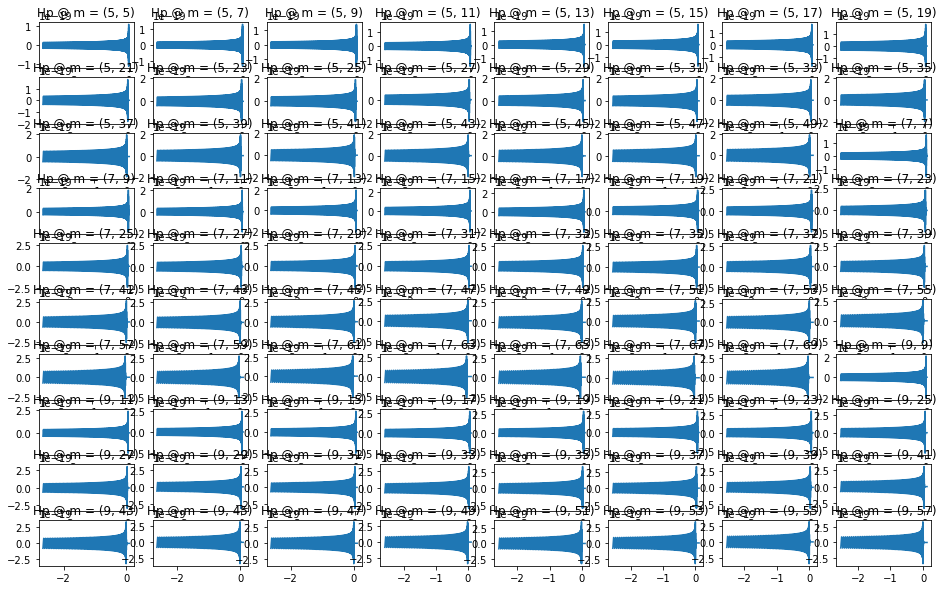

In [14]:
###
###  Read waveform from HDF5, and plot it. 
###

f = h5py.File(HDF5_FILE,'r')

plt.figure(figsize=(16,10))
for i in range(len(m1a)):
    
    plt.subplot(10,8,i+1)
    key = 'waveform/%d'%i
    k1  = 'waveform/%d/t2m'%i
    k2  = 'waveform/%d/hp'%i
    
    m1 = f[key].attrs['m'][0]
    m2 = f[key].attrs['m'][1]
    t2m = f[k1][:]
    hp  = f[k2][:]

    plt.plot(t2m, hp)
    plt.title("Hp @ m = (%d, %d)" % (m1,m2) )
    
    if (i > 78): break
    
f.close()  

In [8]:
###
###  TODO:  load detector noise PSD to 'de-whiten' the waveform 
###
a=[1,2,3,5,6,7]
a[-2:]

[6, 7]

In [64]:
!ls -al


total 1672348
drwxrwxr-x  6 lincy lincy      4096 Jul  3 01:31 .
drwxrwxr-x 22 lincy lincy      4096 Jun  5 10:27 ..
-rw-rw-r--  1 lincy lincy 447939826 Jun 23 01:26 bbh_8192_dm1_test.h5
-rw-rw-r--  1 lincy lincy 459007300 Jun 22 20:39 bbh_8192_dm1_train.h5
-rw-rw-r--  1 lincy lincy 449068714 Jun 22 23:00 bbh_8192_dm1_val.h5
-rw-rw-r--  1 lincy lincy 116412032 Jul  3 01:30 bbh_8192_dm2_test.h5
-rw-rw-r--  1 lincy lincy 121888488 Jul  3 00:06 bbh_8192_dm2_train.h5
-rw-rw-r--  1 lincy lincy 117133701 Jul  3 00:47 bbh_8192_dm2_val.h5
-rw-rw-r--  1 lincy lincy      4079 Apr  7  2017 eric.ini
-rw-rw-r--  1 lincy lincy       121 Apr  6  2017 go
drwxrwxr-x  2 lincy lincy      4096 Feb 21 15:21 .ipynb_checkpoints
drwxrwxr-x  3 lincy lincy      4096 Apr  6  2017 lalinferencenest
-rw-rw-r--  1 lincy lincy       131 Apr  6  2017 NOTE
drwxrwxr-x  2 lincy lincy      4096 Aug 28  2017 otto
drwxrwxr-x  3 lincy lincy      4096 Mar 16 18:48 pycbc
-rw-rw-r--  1 lincy lincy     36753 Sep 15  2016 ROQ_tes